# 🔬 Deep Forensic Theories — การเลือกตั้งครั้งที่ 69

## วิเคราะห์เชิงลึก 8 ทฤษฎีใหม่ที่ยังไม่มีใครทำ

| # | Theory | คำอธิบาย |
|---|--------|----------|
| 1 | Referendum Cross-Validation | เปรียบเทียบ Turnout/บัตรเสีย เลือกตั้ง vs ประชามติ |
| 2 | Ecological Inference | Transition Matrix พรรคปี 66 → 69 |
| 3 | Digit Pair Correlation | Last 2 digits analysis (Beber-Scacco Extended) |
| 4 | Ballot Completion Rate | noVote ประชามติ cross election turnout |
| 5 | Coattail Effect | วัดอิทธิพลหัวขบวน MP → PL |
| 6 | Zipf's Law | Power law fit ต่อคะแนนรายเขต |
| 7 | Party-Specific Benford | Benford's Law แยกรายพรรค |
| 8 | Turnout-Share Correlation | Myagkov-Ordeshook regression |

In [1]:
# === Setup & Load All Data ===
import json
import os
import glob
import warnings
from pathlib import Path
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as sp_stats

warnings.filterwarnings('ignore')

# Thai font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Sarabun', 'Tahoma', 'TH Sarabun New', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100
sns.set_theme(style='whitegrid', font_scale=1.1)

DATA_DIR = Path('../data')
print('✅ Libraries loaded')

✅ Libraries loaded


In [2]:
# === Load all datasets ===

# 1. Constituency (MP results + win66)
with open(DATA_DIR / 'constituency.json', 'r', encoding='utf-8') as f:
    raw_cons = json.load(f)
cons_data = raw_cons['data']

# 2. Party List results
with open(DATA_DIR / 'party_list.json', 'r', encoding='utf-8') as f:
    raw_pl = json.load(f)
pl_data = raw_pl['data']

# 3. Referendum
with open(DATA_DIR / 'referendum.json', 'r', encoding='utf-8') as f:
    raw_ref = json.load(f)
ref_data = raw_ref['data']

# 4. Area code mapping
with open(DATA_DIR / 'area_code/area_code.json', 'r', encoding='utf-8') as f:
    area_mapping = json.load(f)
area_name_map = {item['code']: item['name'] for item in area_mapping['areas']}

# 5. Party overview
with open(DATA_DIR / 'ect_api/info_party_overview.json', 'r', encoding='utf-8') as f:
    parties_raw = json.load(f)

# Build party lookup: PARTY-00XX format
party_name_map = {}  # PARTY-0046 → ประชาชน
party_no_to_code = {}  # '46' → PARTY-0046
party_color_map = {}  # PARTY-0046 → #fd6512
for p in parties_raw:
    pno = p['party_no'].zfill(4)
    code = f"PARTY-{pno}"
    party_name_map[code] = p['name']
    party_no_to_code[p['party_no']] = code
    party_color_map[code] = p.get('color', '#888888')

# 6. MP data (per constituency)
mp_dir = DATA_DIR / 'mp'
pl_dir = DATA_DIR / 'pl'

mp_all = {}  # area_code_str → data
for f_path in sorted(mp_dir.glob('*.json')):
    with open(f_path, 'r', encoding='utf-8') as f:
        d = json.load(f)
    mp_all[str(d['area_code'])] = d

pl_all = {}
for f_path in sorted(pl_dir.glob('*.json')):
    with open(f_path, 'r', encoding='utf-8') as f:
        d = json.load(f)
    pl_all[str(d['area_code'])] = d

# 7. ECT stats (constituency-level turnout)
with open(DATA_DIR / 'ect_api/stats_cons.json', 'r', encoding='utf-8') as f:
    raw_stats = json.load(f)

# 8. Candidate data
with open(DATA_DIR / 'candidates/candidate-data.json', 'r', encoding='utf-8') as f:
    raw_candidates = json.load(f)

print(f'✅ Loaded: {len(cons_data)} constituencies, {len(ref_data)} referendum areas')
print(f'   {len(mp_all)} MP files, {len(pl_all)} PL files')
print(f'   {len(parties_raw)} parties, {len(raw_candidates["candidates"])} candidates')

✅ Loaded: 400 constituencies, 400 referendum areas
   400 MP files, 400 PL files
   57 parties, 3527 candidates


In [3]:
# === Build Master DataFrame ===
# Merge constituency + referendum + party_list into one DF per area

# Constituency DF
cons_rows = []
for c in cons_data:
    code_num = c['areaCode'].replace('AREA-', '')
    winner = c['topEntries'][0] if c['topEntries'] else None
    runner = c['topEntries'][1] if len(c['topEntries']) > 1 else None
    cons_rows.append({
        'areaCode': c['areaCode'],
        'code_num': code_num,
        'area_name': area_name_map.get(code_num, code_num),
        'winnerParty': c.get('winnerPartyCode', ''),
        'win66Party': c.get('win66PartyCode', ''),
        'totalEligible': c.get('totalEligibleVoters', 0),
        'totalStations': c.get('totalStations', 0),
        'winner_votes': winner['voteTotal'] if winner else 0,
        'winner_pct': winner['votePercent'] if winner else 0,
        'runner_votes': runner['voteTotal'] if runner else 0,
        'runner_pct': runner['votePercent'] if runner else 0,
        'margin': (winner['votePercent'] - runner['votePercent']) if (winner and runner) else 0,
        'n_candidates': len(c['topEntries']),
    })
df_cons = pd.DataFrame(cons_rows)

# Referendum DF
ref_rows = []
for r in ref_data:
    code_num = r['areaCode'].replace('AREA-', '')
    ref_rows.append({
        'areaCode': r['areaCode'],
        'code_num': code_num,
        'ref_totalVotes': r['totalVotes'],
        'ref_goodVotes': r['goodVotes'],
        'ref_goodPct': r['goodVotePercent'],
        'ref_badVotes': r['badVotes'],
        'ref_badPct': r['badVotePercent'],
        'ref_noVotes': r['noVotes'],
        'ref_noVotePct': r['noVotePercent'],
        'ref_progressPct': r['voteProgressPercent'],
        'ref_winner': r['winnerAnswerCode'],
        'ref_agree_pct': next((e['votePercent'] for e in r['entries'] if e['answerCode'] == 'agree'), 0),
        'ref_disagree_pct': next((e['votePercent'] for e in r['entries'] if e['answerCode'] == 'disagree'), 0),
    })
df_ref = pd.DataFrame(ref_rows)

# ECT constituency stats (turnout, invalid, blank)
ect_cons_rows = []
for prov in raw_stats.get('result_province', []):
    prov_id = prov['prov_id']
    for cons in prov.get('constituencies', []):
        cid = cons['cons_id']
        if cid.endswith('_0'):  # skip aggregate
            continue
        # Convert cons_id (BKK_1) → area code (1001)
        ect_cons_rows.append({
            'cons_id': cid,
            'prov_id': prov_id,
            'ect_turnout': cons['turn_out'],
            'ect_turnout_pct': cons['percent_turn_out'],
            'ect_valid': cons['valid_votes'],
            'ect_invalid': cons['invalid_votes'],
            'ect_blank': cons['blank_votes'],
            'ect_pl_turnout': cons['party_list_turn_out'],
            'ect_pl_turnout_pct': cons['party_list_percent_turn_out'],
            'ect_pl_valid': cons['party_list_valid_votes'],
            'ect_pl_invalid': cons['party_list_invalid_votes'],
            'ect_pl_blank': cons['party_list_blank_votes'],
            'ect_pct_count': cons['percent_count'],
        })
df_ect = pd.DataFrame(ect_cons_rows)

# Compute turnout pct for constituency from our main data
# We need to get total votes per area from MP files
mp_vote_rows = []
for code, d in mp_all.items():
    total = sum(e['voteTotal'] for e in d['entries'])
    mp_vote_rows.append({'code_num': code, 'mp_total_votes': total})
df_mp_votes = pd.DataFrame(mp_vote_rows)

pl_vote_rows = []
for code, d in pl_all.items():
    total = sum(e['voteTotal'] for e in d['entries'])
    pl_vote_rows.append({'code_num': code, 'pl_total_votes': total})
df_pl_votes = pd.DataFrame(pl_vote_rows)

# Merge all
df = df_cons.merge(df_ref, on=['areaCode', 'code_num'], how='left')
df = df.merge(df_mp_votes, on='code_num', how='left')
df = df.merge(df_pl_votes, on='code_num', how='left')

# Calculate turnout based on available data
df['mp_turnout_pct'] = (df['mp_total_votes'] / df['totalEligible'] * 100).round(2)
df['pl_turnout_pct'] = (df['pl_total_votes'] / df['totalEligible'] * 100).round(2)
df['ref_turnout_pct'] = (df['ref_totalVotes'] / df['totalEligible'] * 100).round(2)

# Winner party name
df['winnerPartyName'] = df['winnerParty'].map(party_name_map).fillna('Unknown')
df['win66PartyName'] = df['win66Party'].map(party_name_map).fillna('Unknown')

print(f'✅ Master DataFrame: {df.shape[0]} rows × {df.shape[1]} columns')
print(f'   Columns: {list(df.columns)}')
df.head(3)

✅ Master DataFrame: 400 rows × 31 columns
   Columns: ['areaCode', 'code_num', 'area_name', 'winnerParty', 'win66Party', 'totalEligible', 'totalStations', 'winner_votes', 'winner_pct', 'runner_votes', 'runner_pct', 'margin', 'n_candidates', 'ref_totalVotes', 'ref_goodVotes', 'ref_goodPct', 'ref_badVotes', 'ref_badPct', 'ref_noVotes', 'ref_noVotePct', 'ref_progressPct', 'ref_winner', 'ref_agree_pct', 'ref_disagree_pct', 'mp_total_votes', 'pl_total_votes', 'mp_turnout_pct', 'pl_turnout_pct', 'ref_turnout_pct', 'winnerPartyName', 'win66PartyName']


,areaCode,code_num,area_name,winnerParty,win66Party,totalEligible,totalStations,winner_votes,winner_pct,runner_votes,...,ref_winner,ref_agree_pct,ref_disagree_pct,mp_total_votes,pl_total_votes,mp_turnout_pct,pl_turnout_pct,ref_turnout_pct,winnerPartyName,win66PartyName
0,AREA-7603,7603,เพชรบุรี เขต 3,PARTY-0037,PARTY-0006,131557,278,67129,75.72,12514,...,agree,56.30,43.70,88653,86582,67.39,65.81,72.94,ภูมิใจไทย,รวมไทยสร้างชาติ
1,AREA-2301,2301,ตราด เขต 1,PARTY-0037,PARTY-0046,176920,343,62391,59.74,22492,...,agree,54.94,45.06,104438,103587,59.03,58.55,64.02,ภูมิใจไทย,ประชาชน
2,AREA-7602,7602,เพชรบุรี เขต 2,PARTY-0037,PARTY-0037,139326,251,63365,71.37,16712,...,agree,58.27,41.73,88789,88381,63.73,63.43,69.63,ภูมิใจไทย,ภูมิใจไทย


---
## 🔬 Theory 1: Referendum Cross-Validation
**ทฤษฎี:** การเลือกตั้งและประชามติจัดในวันเดียวกัน → Turnout ควรใกล้เคียงกัน  
ถ้าเขตไหน election turnout สูงแต่ referendum turnout ต่ำ (หรือกลับกัน) → ผิดปกติ  
เปรียบเทียบบัตรเสียของทั้ง 2 ระบบด้วย

🔬 Theory 1: Referendum Cross-Validation

📊 จำนวนเขตที่วิเคราะห์: 400

--- Turnout Difference (Election - Referendum) ---
   ค่าเฉลี่ย:    -4.40%
   ค่าเบี่ยงเบน: 3.74%
   Min:          -27.52%
   Max:          6.05%
   Outliers (>2σ): 254 เขต


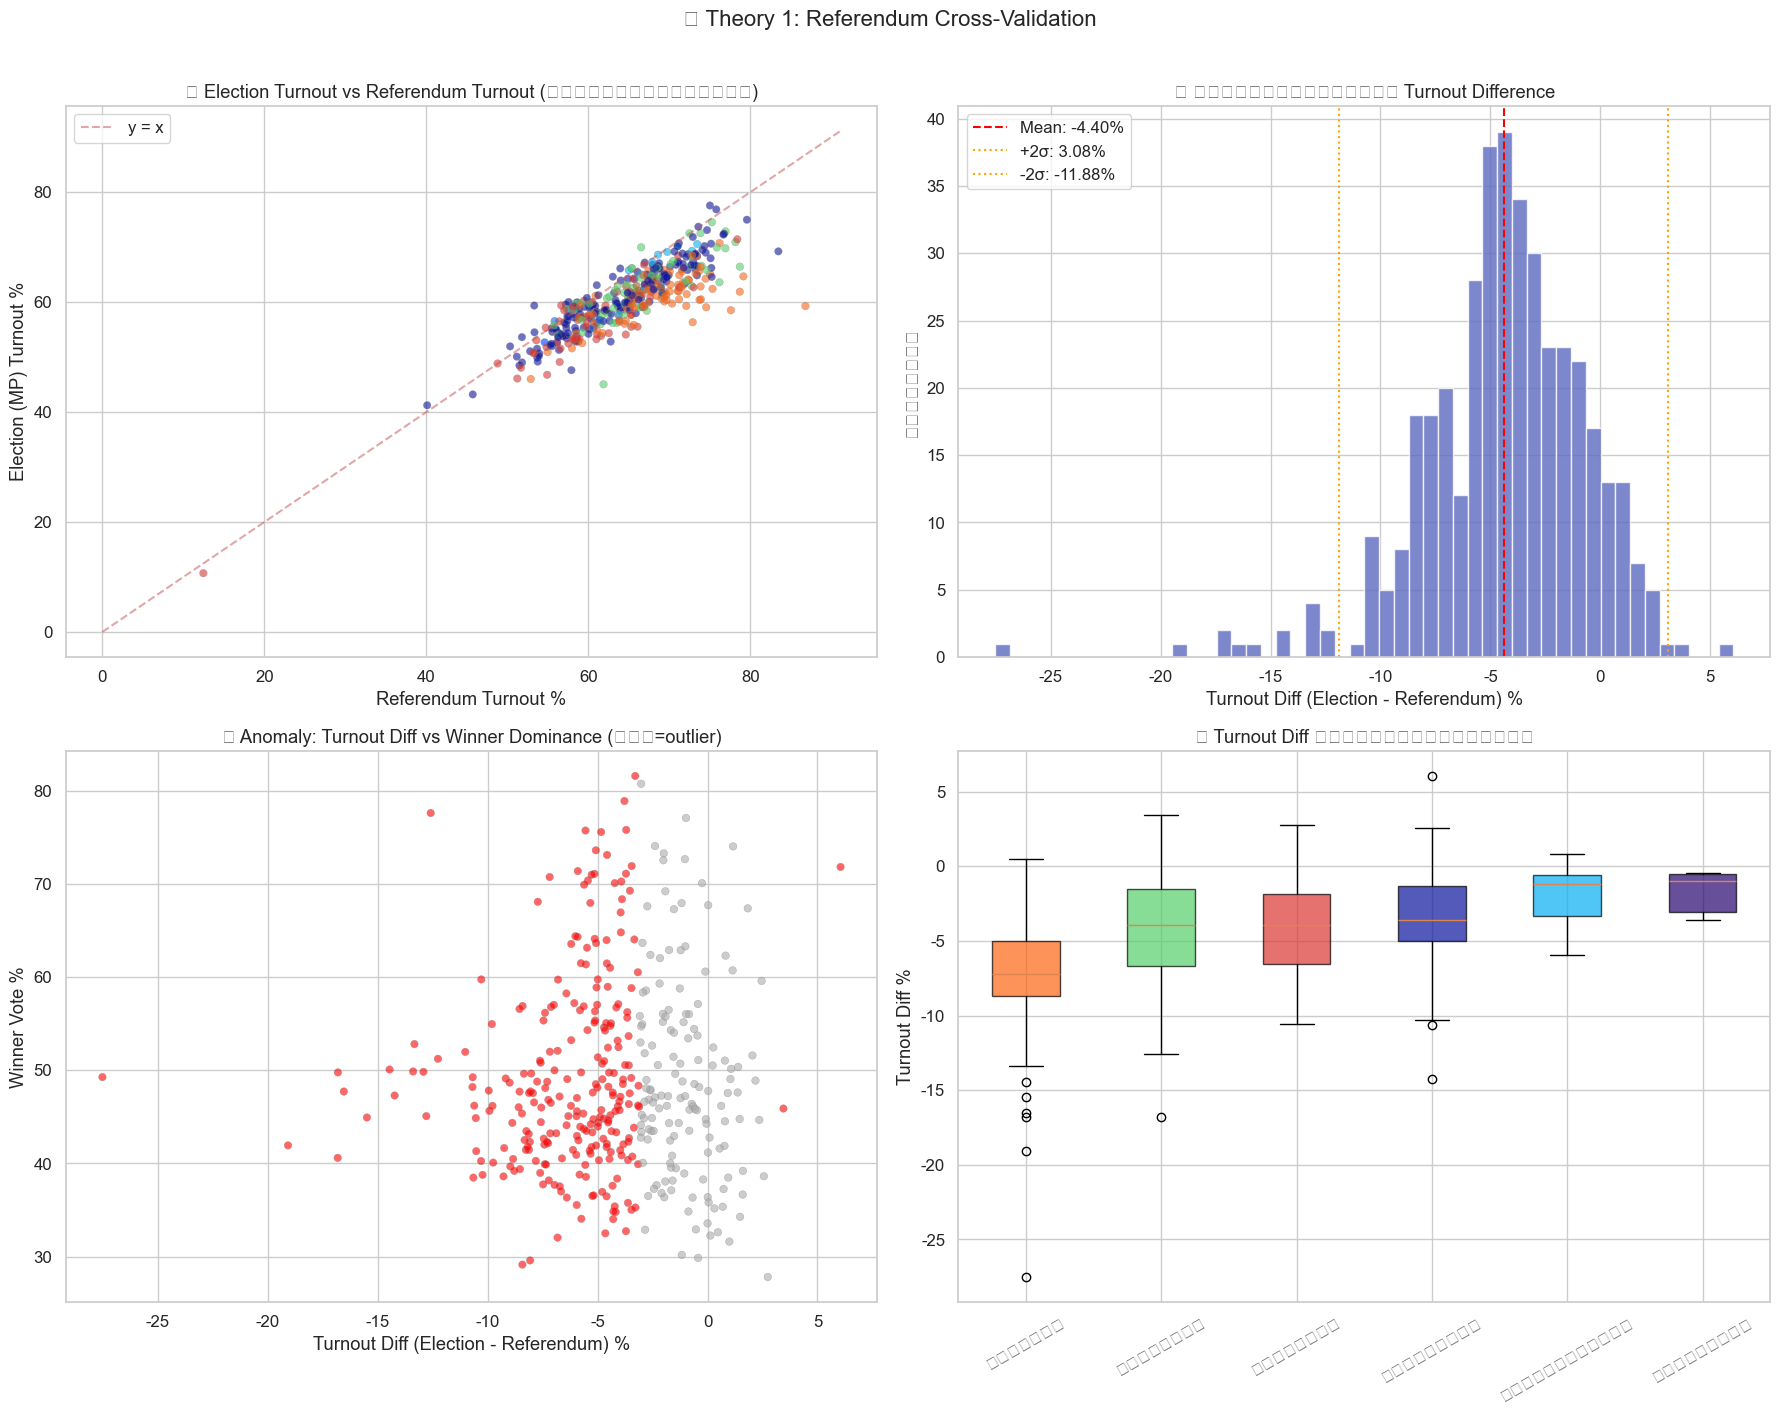


📋 Top 15 เขตที่ Turnout Diff มากที่สุด:
                 เขต พรรคผู้ชนะ  Turnout เลือกตั้ง%  Turnout ประชามติ%  Diff%  Winner Vote%
     เชียงใหม่ เขต 1    ประชาชน               59.27              86.79 -27.52         49.26
กรุงเทพมหานคร เขต 20    ประชาชน               58.51              77.59 -19.08         41.93
           ตาก เขต 2   กล้าธรรม               45.04              61.86 -16.82         40.59
กรุงเทพมหานคร เขต 23    ประชาชน               61.88              78.69 -16.81         49.76
กรุงเทพมหานคร เขต 33    ประชาชน               56.33              72.87 -16.54         47.71
        ชลบุรี เขต 6    ประชาชน               59.05              74.54 -15.49         44.92
 กรุงเทพมหานคร เขต 5    ประชาชน               64.67              79.13 -14.46         50.07
        ชลบุรี เขต 1  ภูมิใจไทย               69.22              83.45 -14.23         47.28
      ปทุมธานี เขต 3    ประชาชน               60.49              73.88 -13.39         49.86
         ลำพูน เขต 1    ประชาชน        

In [4]:
# === Theory 1: Referendum Cross-Validation ===

df_t1 = df.dropna(subset=['ref_totalVotes', 'mp_total_votes']).copy()
df_t1 = df_t1[df_t1['totalEligible'] > 0].copy()

# 1a. Turnout difference: election vs referendum
df_t1['turnout_diff'] = df_t1['mp_turnout_pct'] - df_t1['ref_turnout_pct']
df_t1['turnout_diff_abs'] = df_t1['turnout_diff'].abs()

# Flag outliers (> 2 std dev)
mean_diff = df_t1['turnout_diff'].mean()
std_diff = df_t1['turnout_diff'].std()
df_t1['turnout_outlier'] = df_t1['turnout_diff_abs'] > (mean_diff + 2 * std_diff)

# 1b. Bad vote comparison
df_t1['ref_bad_rate'] = df_t1['ref_badPct']

# Summary
print('=' * 70)
print('🔬 Theory 1: Referendum Cross-Validation')
print('=' * 70)
print(f'\n📊 จำนวนเขตที่วิเคราะห์: {len(df_t1)}')
print(f'\n--- Turnout Difference (Election - Referendum) ---')
print(f'   ค่าเฉลี่ย:    {df_t1["turnout_diff"].mean():.2f}%')
print(f'   ค่าเบี่ยงเบน: {df_t1["turnout_diff"].std():.2f}%')
print(f'   Min:          {df_t1["turnout_diff"].min():.2f}%')
print(f'   Max:          {df_t1["turnout_diff"].max():.2f}%')
print(f'   Outliers (>2σ): {df_t1["turnout_outlier"].sum()} เขต')

# Plots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Scatter: MP Turnout vs Referendum Turnout
ax = axes[0, 0]
colors = [party_color_map.get(wp, '#888') for wp in df_t1['winnerParty']]
ax.scatter(df_t1['ref_turnout_pct'], df_t1['mp_turnout_pct'], c=colors, alpha=0.6, s=30, edgecolors='gray', linewidth=0.3)
max_val = max(df_t1['ref_turnout_pct'].max(), df_t1['mp_turnout_pct'].max()) * 1.05
ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='y = x')
ax.set_xlabel('Referendum Turnout %')
ax.set_ylabel('Election (MP) Turnout %')
ax.set_title('📊 Election Turnout vs Referendum Turnout (สีตามพรรคผู้ชนะ)')
ax.legend()

# 2. Histogram of turnout difference
ax = axes[0, 1]
ax.hist(df_t1['turnout_diff'], bins=50, color='#5C6BC0', edgecolor='white', alpha=0.8)
ax.axvline(x=mean_diff, color='red', linestyle='--', label=f'Mean: {mean_diff:.2f}%')
ax.axvline(x=mean_diff + 2*std_diff, color='orange', linestyle=':', label=f'+2σ: {mean_diff + 2*std_diff:.2f}%')
ax.axvline(x=mean_diff - 2*std_diff, color='orange', linestyle=':', label=f'-2σ: {mean_diff - 2*std_diff:.2f}%')
ax.set_xlabel('Turnout Diff (Election - Referendum) %')
ax.set_ylabel('จำนวนเขต')
ax.set_title('📊 การกระจายตัวของ Turnout Difference')
ax.legend()

# 3. Scatter: Winner Vote % vs Turnout Diff (Anomaly Detection)
ax = axes[1, 0]
sc = ax.scatter(df_t1['turnout_diff'], df_t1['winner_pct'], 
                c=df_t1['turnout_outlier'].map({True: 'red', False: '#aaa'}),
                alpha=0.6, s=30, edgecolors='gray', linewidth=0.3)
ax.set_xlabel('Turnout Diff (Election - Referendum) %')
ax.set_ylabel('Winner Vote %')
ax.set_title('🚩 Anomaly: Turnout Diff vs Winner Dominance (แดง=outlier)')

# 4. Turnout Diff by Winner Party (boxplot)
ax = axes[1, 1]
top_parties = df_t1['winnerPartyName'].value_counts().head(6).index.tolist()
df_plot = df_t1[df_t1['winnerPartyName'].isin(top_parties)]
party_order = df_plot.groupby('winnerPartyName')['turnout_diff'].median().sort_values().index
bp = ax.boxplot([df_plot[df_plot['winnerPartyName'] == p]['turnout_diff'] for p in party_order],
                labels=party_order, patch_artist=True, vert=True)
for patch, pname in zip(bp['boxes'], party_order):
    matching = df_t1[df_t1['winnerPartyName'] == pname]['winnerParty'].iloc[0]
    patch.set_facecolor(party_color_map.get(matching, '#888'))
    patch.set_alpha(0.7)
ax.set_ylabel('Turnout Diff %')
ax.set_title('📊 Turnout Diff แยกตามพรรคผู้ชนะ')
ax.tick_params(axis='x', rotation=30)

plt.suptitle('🔬 Theory 1: Referendum Cross-Validation', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

# Top outliers table
print('\n📋 Top 15 เขตที่ Turnout Diff มากที่สุด:')
top_outliers = df_t1.nlargest(15, 'turnout_diff_abs')[['area_name', 'winnerPartyName', 'mp_turnout_pct', 'ref_turnout_pct', 'turnout_diff', 'winner_pct']].copy()
top_outliers.columns = ['เขต', 'พรรคผู้ชนะ', 'Turnout เลือกตั้ง%', 'Turnout ประชามติ%', 'Diff%', 'Winner Vote%']
print(top_outliers.to_string(index=False))

---
## 🔬 Theory 2: Ecological Inference — Transition Matrix
**ทฤษฎี:** วิเคราะห์ว่าพรรคที่ชนะปี 66 → ในปี 69 เปลี่ยนไปเป็นพรรคอะไร  
ทำ Transition Matrix ดูการเปลี่ยนแปลง "ย้ายฐานเสียง"

🔬 Theory 2: Ecological Inference — Transition Matrix (66 → 69)

📊 จำนวนเขตที่มีข้อมูลเปรียบเทียบ: 386

--- Transition Count (จำนวนเขต) ---
win69Name        ภูมิใจไทย  ประชาชน  เพื่อไทย  กล้าธรรม  ประชาธิปัตย์  พลังประชารัฐ  ประชาชาติ  ไทรวมพลัง
win66Name                                                                                                
ประชาชน                 20       78         3        10             1             0          0          0
เพื่อไทย                39        8        48        14             0             1          0          0
ภูมิใจไทย               64        0         4         0             0             0          0          0
พลังประชารัฐ            13        1         2        19             1             3          0          0
รวมไทยสร้างชาติ         13        0         1         5             2             0          0          1
ประชาธิปัตย์             8        0         0         7             6             0          0          1
ประชาชาติ    

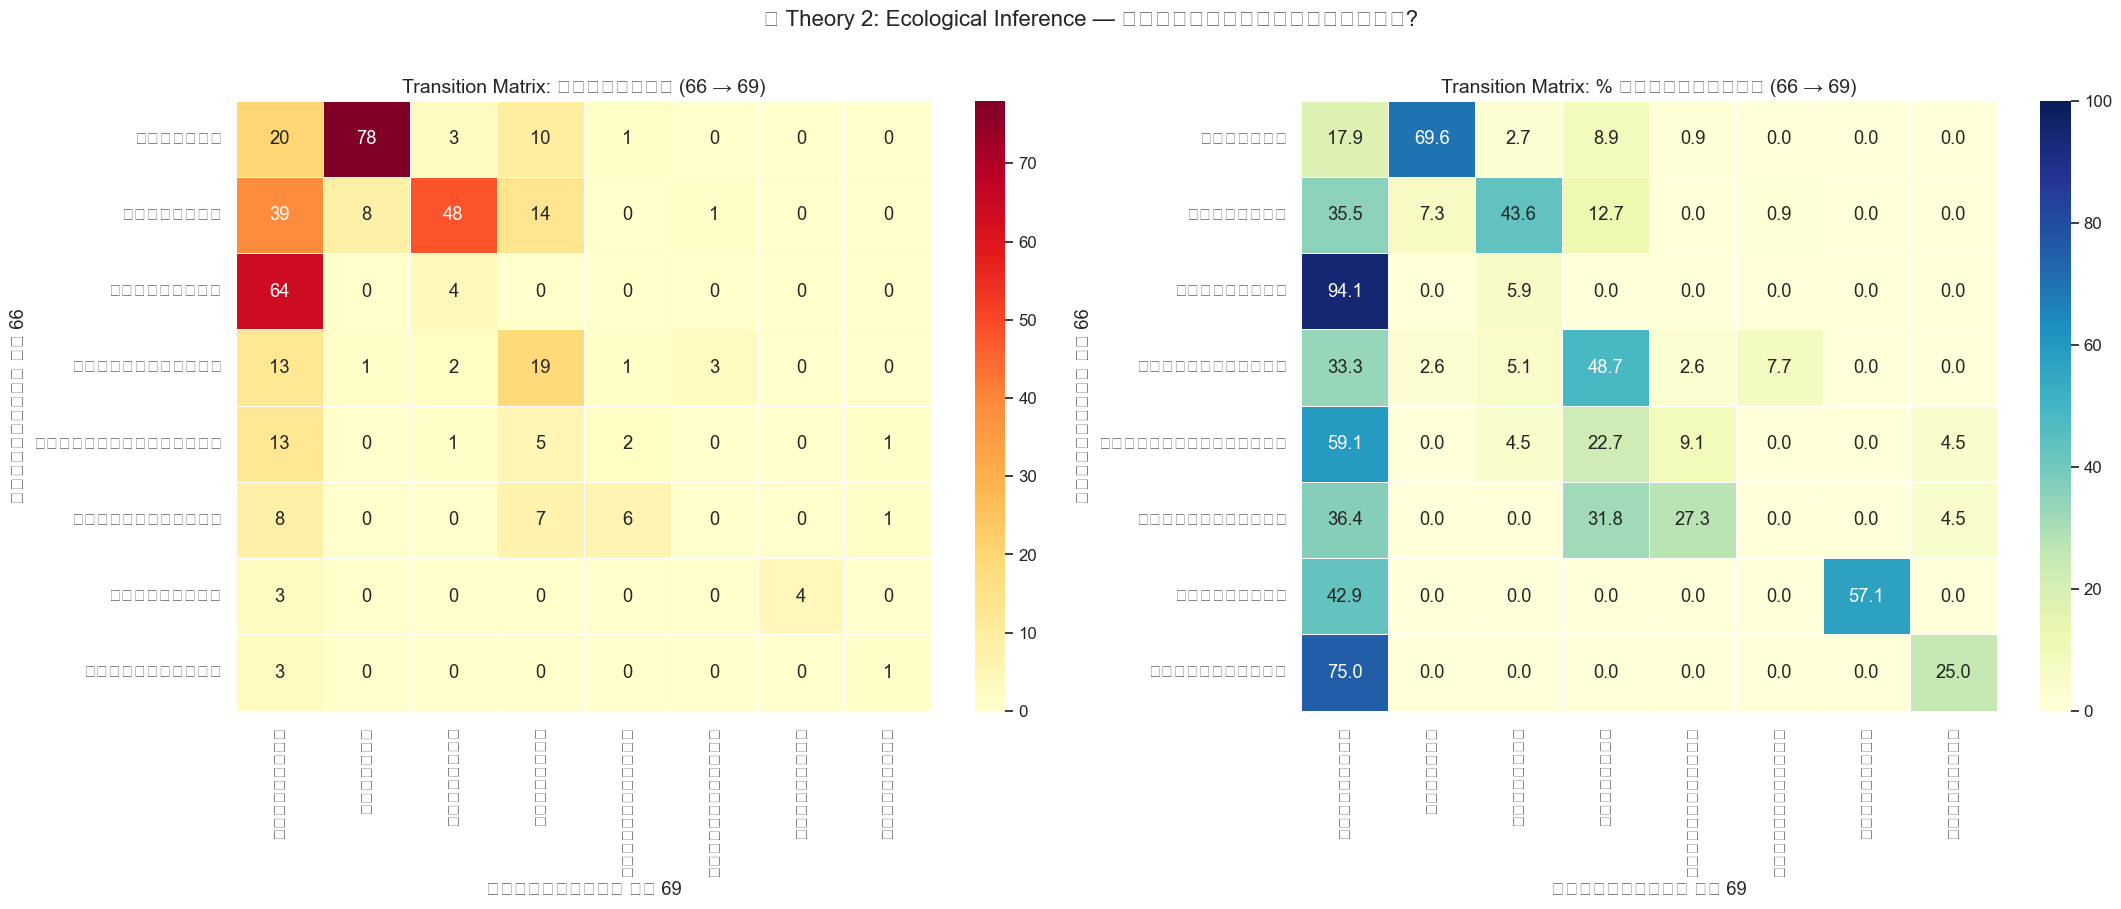


📋 สรุป: แต่ละพรรครักษาที่นั่งได้กี่%?
  ประชาชน: ปี66=112 เขต → รักษา 69.6% | ปี69 ชนะรวม 87 เขต
  เพื่อไทย: ปี66=110 เขต → รักษา 43.6% | ปี69 ชนะรวม 58 เขต
  ภูมิใจไทย: ปี66=68 เขต → รักษา 94.1% | ปี69 ชนะรวม 163 เขต
  พลังประชารัฐ: ปี66=39 เขต → รักษา 7.7% | ปี69 ชนะรวม 4 เขต
  ประชาธิปัตย์: ปี66=22 เขต → รักษา 27.3% | ปี69 ชนะรวม 10 เขต
  ประชาชาติ: ปี66=7 เขต → รักษา 57.1% | ปี69 ชนะรวม 4 เขต


In [5]:
# === Theory 2: Ecological Inference — Transition Matrix ===

df_t2 = df[df['win66Party'].notna() & (df['win66Party'] != '')].copy()
df_t2['win66Name'] = df_t2['win66Party'].map(party_name_map).fillna('Unknown')
df_t2['win69Name'] = df_t2['winnerParty'].map(party_name_map).fillna('Unknown')

# Transition Matrix: rows = party66, cols = party69
# Focus on main parties
main_66 = df_t2['win66Name'].value_counts().head(8).index.tolist()
main_69 = df_t2['win69Name'].value_counts().head(8).index.tolist()
all_main = sorted(set(main_66 + main_69))

trans = pd.crosstab(df_t2['win66Name'], df_t2['win69Name'])

# Filter to main parties
trans_main = trans.reindex(index=main_66, columns=main_69, fill_value=0)

# Normalize by row (% of 66 seats that went to each 69 party)
trans_pct = trans_main.div(trans_main.sum(axis=1), axis=0) * 100

print('=' * 70)
print('🔬 Theory 2: Ecological Inference — Transition Matrix (66 → 69)')
print('=' * 70)
print(f'\n📊 จำนวนเขตที่มีข้อมูลเปรียบเทียบ: {len(df_t2)}')
print(f'\n--- Transition Count (จำนวนเขต) ---')
print(trans_main.to_string())
print(f'\n--- Transition Percent (%) ---')
print(trans_pct.round(1).to_string())

# Heatmap
fig, axes = plt.subplots(1, 2, figsize=(22, 9))

# Count heatmap
ax = axes[0]
sns.heatmap(trans_main, annot=True, fmt='d', cmap='YlOrRd', ax=ax, linewidths=0.5)
ax.set_title('Transition Matrix: จำนวนเขต (66 → 69)', fontsize=14)
ax.set_xlabel('พรรคผู้ชนะ ปี 69')
ax.set_ylabel('พรรคผู้ชนะ ปี 66')

# Percentage heatmap
ax = axes[1]
sns.heatmap(trans_pct, annot=True, fmt='.1f', cmap='YlGnBu', ax=ax, linewidths=0.5,
            vmin=0, vmax=100)
ax.set_title('Transition Matrix: % ของเขตเดิม (66 → 69)', fontsize=14)
ax.set_xlabel('พรรคผู้ชนะ ปี 69')
ax.set_ylabel('พรรคผู้ชนะ ปี 66')

plt.suptitle('🔬 Theory 2: Ecological Inference — ใครย้ายไปเลือกใคร?', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

# Summary: who retained, who lost
print('\n📋 สรุป: แต่ละพรรครักษาที่นั่งได้กี่%?')
for party in main_66:
    if party in trans_pct.index and party in trans_pct.columns:
        retain = trans_pct.loc[party, party]
        total66 = trans_main.loc[party].sum()
        total69 = trans_main[party].sum() if party in trans_main.columns else 0
        print(f'  {party}: ปี66={total66} เขต → รักษา {retain:.1f}% | ปี69 ชนะรวม {total69} เขต')

---
## 🔬 Theory 3: Digit Pair Correlation (Beber-Scacco Extended)
**ทฤษฎี:** ตัวเลข 2 หลักสุดท้ายของคะแนนควรกระจายสม่ำเสมอ  
มนุษย์ที่ "แต่ง" ตัวเลข จะหลีกเลี่ยง repeated digits (11, 22, 33) และ sequential (12, 23, 34)

🔬 Theory 3: Digit Pair Correlation (Beber-Scacco Extended)

--- สส.แบ่งเขต (MP) (3,488 vote entries) ---
  Last Digit:   χ²=10.25, p=0.330539 → ✅ PASS
  Tens Digit:   χ²=6.57, p=0.681794 → ✅ PASS
  Last 2 Digit: χ²=107.58, p=0.260965 → ✅ PASS
  Repeated (11,22..): observed=334, expected=349 (ratio=0.958)
  Sequential (12,23..): observed=364, expected=314 (ratio=1.160)

--- บัญชีรายชื่อ (PL) (22,025 vote entries) ---
  Last Digit:   χ²=16.30, p=0.060842 → ✅ PASS
  Tens Digit:   χ²=1415.65, p=0.000000 → ⚠️ FAIL
  Last 2 Digit: χ²=1507.24, p=0.000000 → ⚠️ FAIL
  Repeated (11,22..): observed=2206, expected=2202 (ratio=1.002)
  Sequential (12,23..): observed=1958, expected=1982 (ratio=0.988)


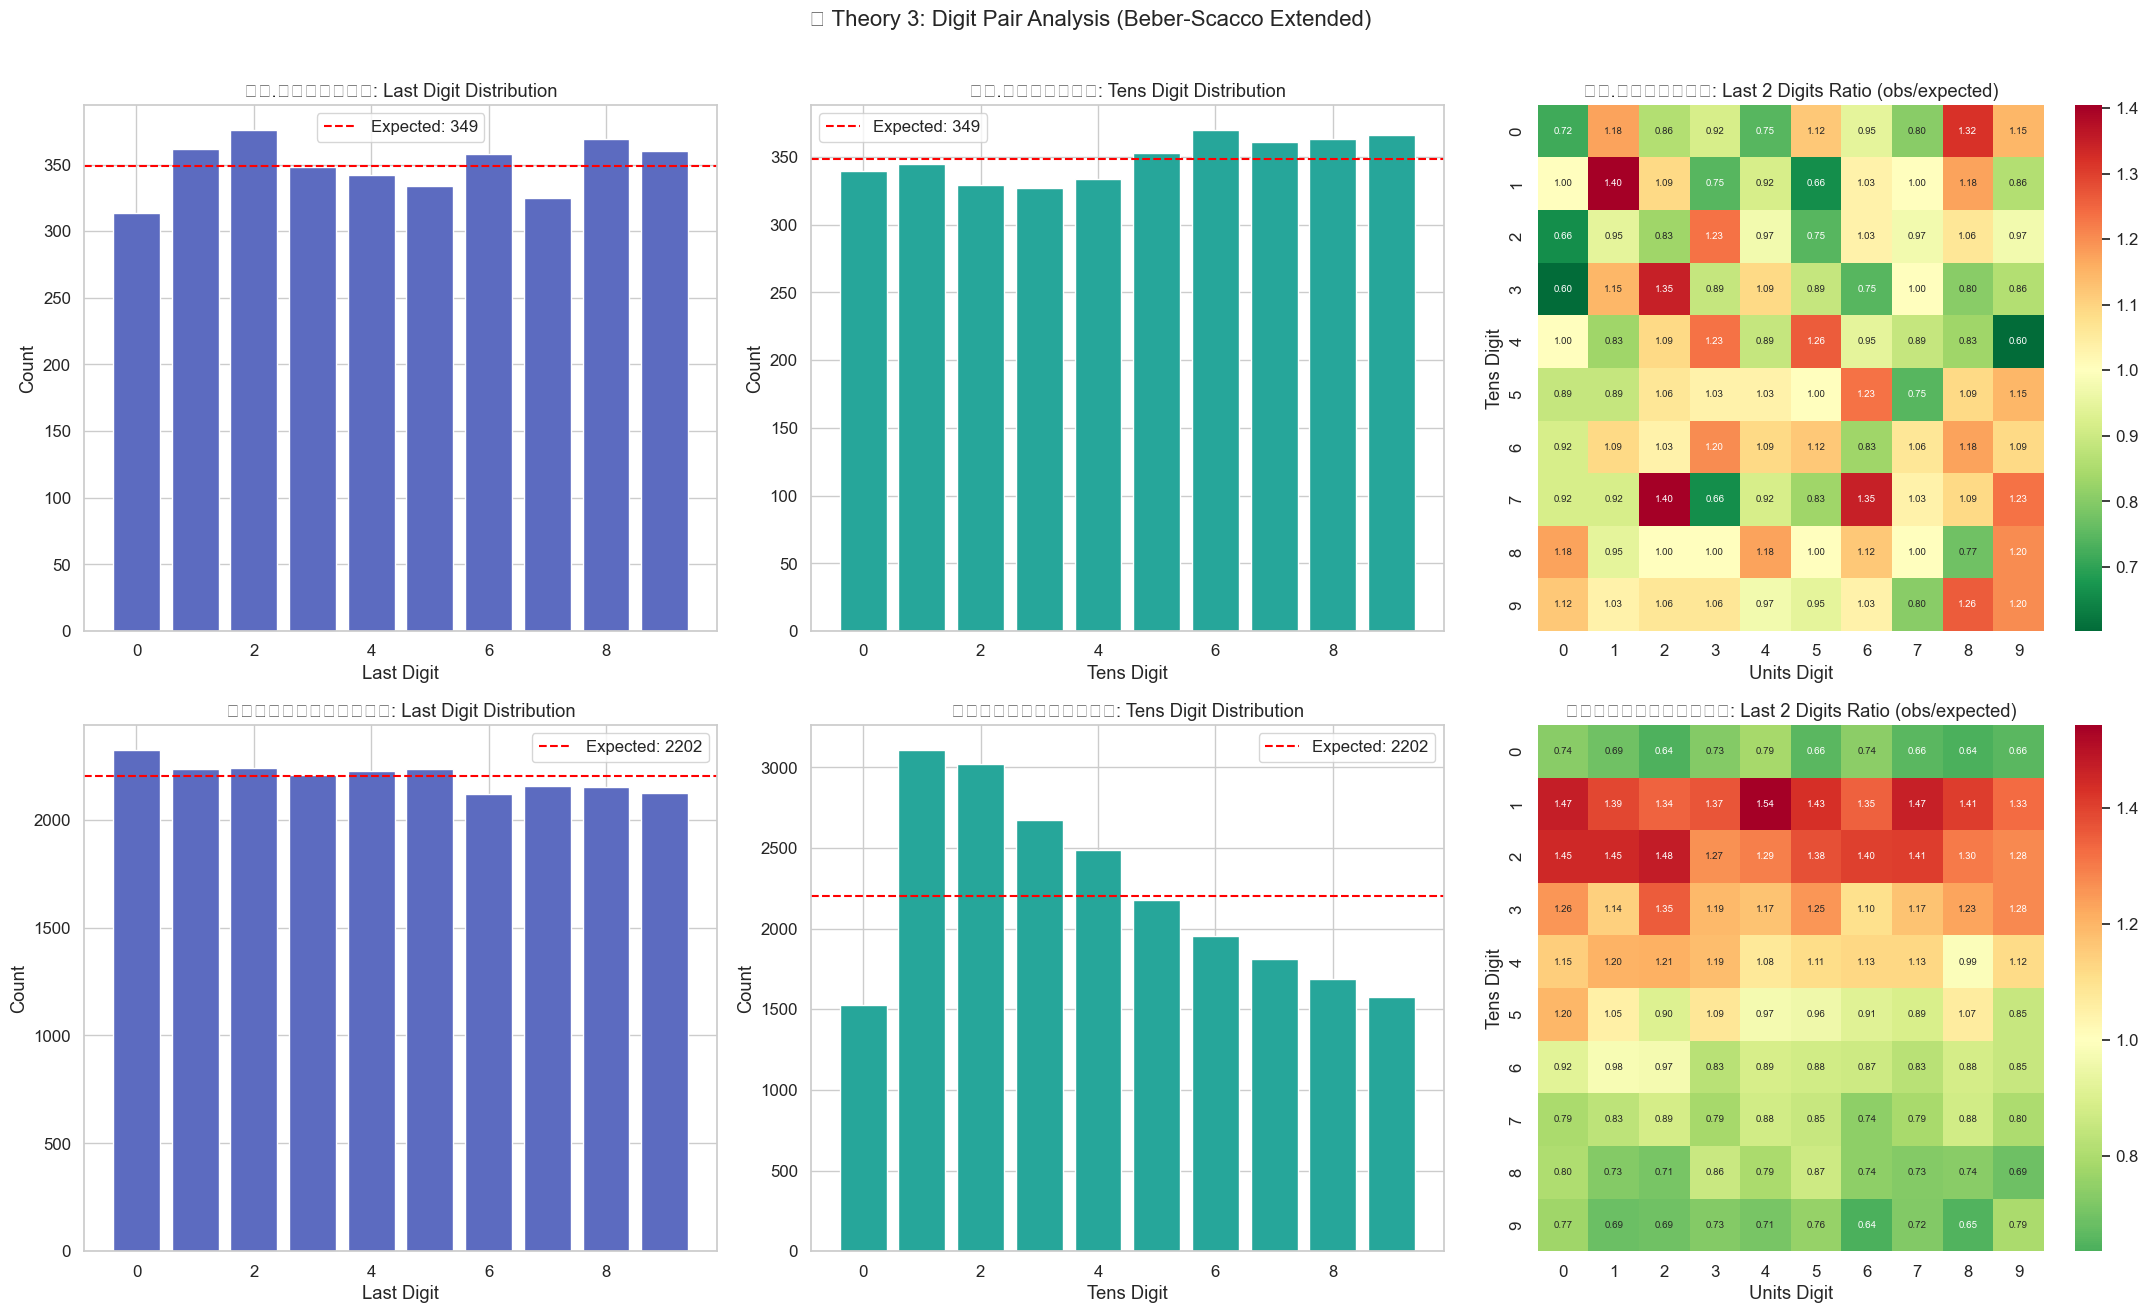

In [6]:
# === Theory 3: Digit Pair Correlation (Beber-Scacco Extended) ===

# Collect all vote totals (from MP results)
all_vote_totals = []
for code, d in mp_all.items():
    for entry in d['entries']:
        v = entry['voteTotal']
        if v >= 10:  # need at least 2 digits
            all_vote_totals.append(v)

# Also collect PL vote totals
pl_vote_totals = []
for code, d in pl_all.items():
    for entry in d['entries']:
        v = entry['voteTotal']
        if v >= 10:
            pl_vote_totals.append(v)

def analyze_last_two_digits(votes, label):
    """Analyze last 2 digits distribution"""
    last_two = [v % 100 for v in votes]
    last_one = [v % 10 for v in votes]
    tens = [(v % 100) // 10 for v in votes]
    
    # 1. Last digit uniformity (should be ~10% each for 0-9)
    last_digit_counts = Counter(last_one)
    expected_last = len(votes) / 10
    observed_last = [last_digit_counts.get(i, 0) for i in range(10)]
    chi2_last, p_last = sp_stats.chisquare(observed_last, [expected_last] * 10)
    
    # 2. Tens digit uniformity
    tens_counts = Counter(tens)
    observed_tens = [tens_counts.get(i, 0) for i in range(10)]
    chi2_tens, p_tens = sp_stats.chisquare(observed_tens, [expected_last] * 10)
    
    # 3. Last 2 digits uniformity (should be ~1% each for 00-99)
    two_digit_counts = Counter(last_two)
    expected_two = len(votes) / 100
    observed_two = [two_digit_counts.get(i, 0) for i in range(100)]
    chi2_two, p_two = sp_stats.chisquare(observed_two, [expected_two] * 100)
    
    # 4. Repeated digits (00, 11, 22, ... 99)
    repeated = [i * 11 for i in range(10)]  # 00, 11, 22, ..., 99
    repeated_count = sum(two_digit_counts.get(r, 0) for r in repeated)
    repeated_expected = len(votes) * 10 / 100  # 10 out of 100 pairs
    
    # 5. Sequential pairs (01, 12, 23, ..., 89)
    sequential = [i * 10 + (i + 1) for i in range(9)]  # 01, 12, 23, ..., 89
    sequential_count = sum(two_digit_counts.get(s, 0) for s in sequential)
    sequential_expected = len(votes) * 9 / 100
    
    print(f'\n--- {label} ({len(votes):,} vote entries) ---')
    print(f'  Last Digit:   χ²={chi2_last:.2f}, p={p_last:.6f} → {"⚠️ FAIL" if p_last < 0.05 else "✅ PASS"}')
    print(f'  Tens Digit:   χ²={chi2_tens:.2f}, p={p_tens:.6f} → {"⚠️ FAIL" if p_tens < 0.05 else "✅ PASS"}')
    print(f'  Last 2 Digit: χ²={chi2_two:.2f}, p={p_two:.6f} → {"⚠️ FAIL" if p_two < 0.05 else "✅ PASS"}')
    print(f'  Repeated (11,22..): observed={repeated_count}, expected={repeated_expected:.0f} (ratio={repeated_count/repeated_expected:.3f})')
    print(f'  Sequential (12,23..): observed={sequential_count}, expected={sequential_expected:.0f} (ratio={sequential_count/sequential_expected:.3f})')
    
    return last_one, tens, last_two, two_digit_counts

print('=' * 70)
print('🔬 Theory 3: Digit Pair Correlation (Beber-Scacco Extended)')
print('=' * 70)

ld_mp, td_mp, lt_mp, tc_mp = analyze_last_two_digits(all_vote_totals, 'สส.แบ่งเขต (MP)')
ld_pl, td_pl, lt_pl, tc_pl = analyze_last_two_digits(pl_vote_totals, 'บัญชีรายชื่อ (PL)')

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(22, 13))

for row, (ld, td, lt, tc, label) in enumerate([
    (ld_mp, td_mp, lt_mp, tc_mp, 'สส.แบ่งเขต'),
    (ld_pl, td_pl, lt_pl, tc_pl, 'บัญชีรายชื่อ'),
]):
    # Last digit
    ax = axes[row, 0]
    counts = [ld.count(i) for i in range(10)]
    expected = len(ld) / 10
    bars = ax.bar(range(10), counts, color='#5C6BC0', edgecolor='white')
    ax.axhline(y=expected, color='red', linestyle='--', label=f'Expected: {expected:.0f}')
    ax.set_xlabel('Last Digit')
    ax.set_ylabel('Count')
    ax.set_title(f'{label}: Last Digit Distribution')
    ax.legend()
    
    # Tens digit
    ax = axes[row, 1]
    counts = [td.count(i) for i in range(10)]
    bars = ax.bar(range(10), counts, color='#26A69A', edgecolor='white')
    ax.axhline(y=expected, color='red', linestyle='--', label=f'Expected: {expected:.0f}')
    ax.set_xlabel('Tens Digit')
    ax.set_ylabel('Count')
    ax.set_title(f'{label}: Tens Digit Distribution')
    ax.legend()
    
    # 2D heatmap of last 2 digits
    ax = axes[row, 2]
    grid = np.zeros((10, 10))
    for pair, count in tc.items():
        r, c = pair // 10, pair % 10
        grid[r][c] = count
    expected_2d = len(lt) / 100
    grid_ratio = grid / expected_2d  # ratio to expected
    sns.heatmap(grid_ratio, ax=ax, cmap='RdYlGn_r', center=1.0,
                xticklabels=range(10), yticklabels=range(10),
                annot=True, fmt='.2f', annot_kws={'fontsize': 7})
    ax.set_xlabel('Units Digit')
    ax.set_ylabel('Tens Digit')
    ax.set_title(f'{label}: Last 2 Digits Ratio (obs/expected)')

plt.suptitle('🔬 Theory 3: Digit Pair Analysis (Beber-Scacco Extended)', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

---
## 🔬 Theory 4: Ballot Completion Rate Paradox
**ทฤษฎี:** คนที่ถูกซื้อเสียง → กาครบทุกใบ (completion rate สูง)  
คนอิสระ → อาจไม่กาประชามติ (noVote สูง)  
เขตที่ noVote ประชามติต่ำผิดปกติ + election turnout สูง → น่าสงสัย

🔬 Theory 4: Ballot Completion Rate Paradox

📊 จำนวนเขต: 400

--- Referendum Completion Rate (100 - noVote%) ---
   ค่าเฉลี่ย: 91.55%
   Median:    91.53%
   Q90:       94.24% (threshold)

--- Vote Gap (Election - Referendum) ---
   ค่าเฉลี่ย: -5857 เสียง (-4.40%)

🚩 เขตที่น่าสงสัย (high completion + high turnout): 6


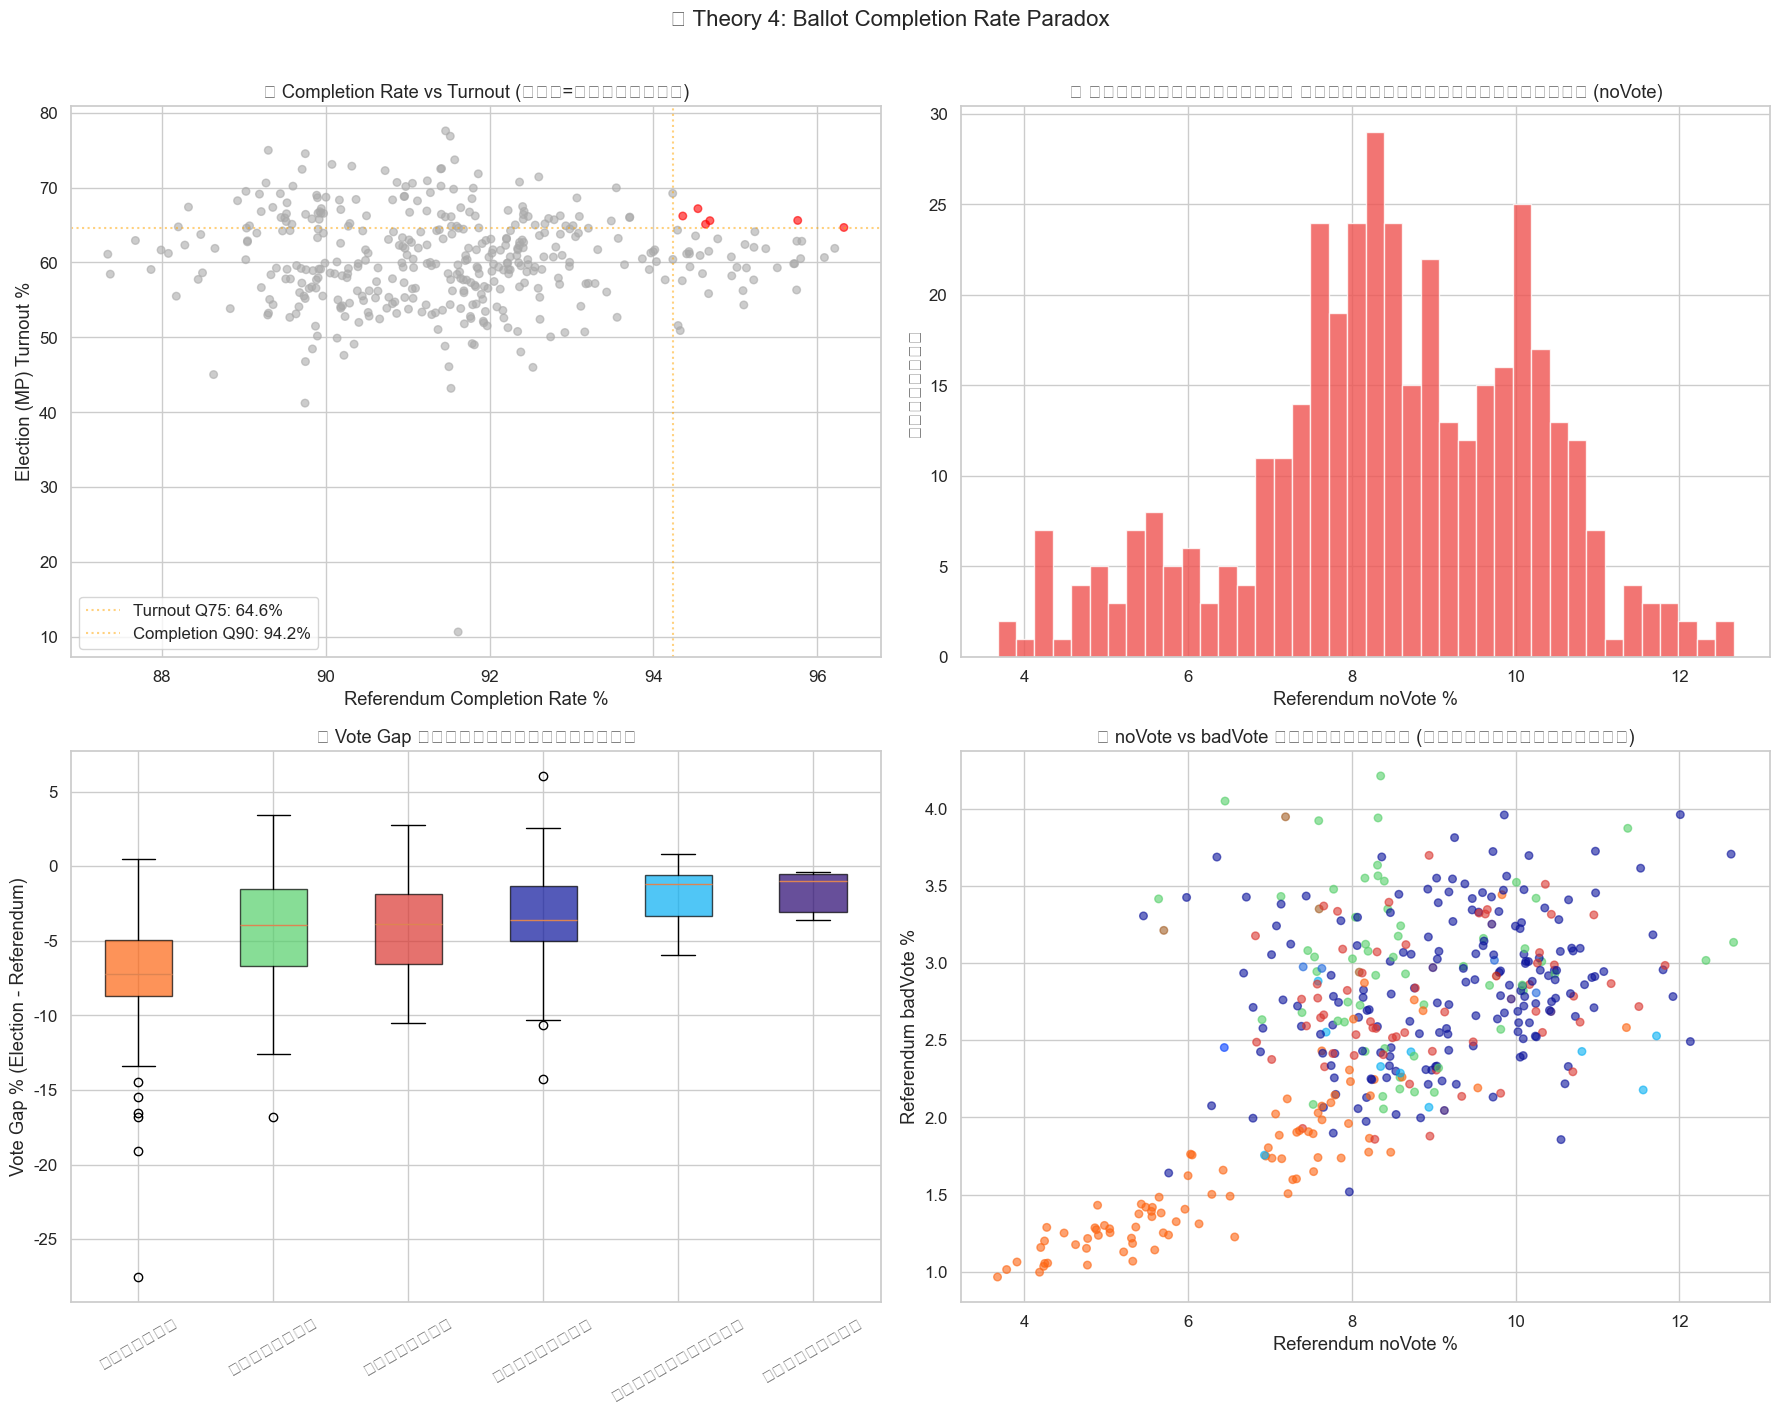


📋 เขตที่น่าสงสัย (High Completion + High Turnout):
                 เขต      พรรค  Completion%  Turnout%  noVote%  Winner%
 กรุงเทพมหานคร เขต 5   ประชาชน    96.326365     64.67 3.673635    50.07
กรุงเทพมหานคร เขต 12   ประชาชน    95.762760     65.61 4.237240    47.72
กรุงเทพมหานคร เขต 11   ประชาชน    94.690986     65.58 5.309014    40.91
กรุงเทพมหานคร เขต 31   ประชาชน    94.637709     65.10 5.362291    45.63
      นราธิวาส เขต 4 ภูมิใจไทย    94.544410     67.18 5.455590    50.50
       ปัตตานี เขต 4  กล้าธรรม    94.359504     66.20 5.640496    37.65


In [7]:
# === Theory 4: Ballot Completion Rate Paradox ===

df_t4 = df.dropna(subset=['ref_noVotePct', 'ref_totalVotes']).copy()
df_t4 = df_t4[df_t4['totalEligible'] > 0].copy()

# Completion rate = 1 - (noVote / totalVotes)
df_t4['ref_completion_rate'] = 100 - df_t4['ref_noVotePct']

# Bad vote rate ในเลือกตั้ง (ถ้ามี)
# Proxy: (mp_total_votes / totalEligible) vs (ref_totalVotes / totalEligible)
df_t4['vote_gap'] = df_t4['mp_total_votes'] - df_t4['ref_totalVotes']  # diff ระหว่าง 2 ระบบ
df_t4['vote_gap_pct'] = (df_t4['vote_gap'] / df_t4['totalEligible'] * 100).round(2)

# Flag: high completion + high turnout
ref_comp_q90 = df_t4['ref_completion_rate'].quantile(0.90)
turnout_q75 = df_t4['mp_turnout_pct'].quantile(0.75)
df_t4['high_completion'] = df_t4['ref_completion_rate'] > ref_comp_q90
df_t4['suspicious_combo'] = (df_t4['ref_completion_rate'] > ref_comp_q90) & (df_t4['mp_turnout_pct'] > turnout_q75)

print('=' * 70)
print('🔬 Theory 4: Ballot Completion Rate Paradox')
print('=' * 70)
print(f'\n📊 จำนวนเขต: {len(df_t4)}')
print(f'\n--- Referendum Completion Rate (100 - noVote%) ---')
print(f'   ค่าเฉลี่ย: {df_t4["ref_completion_rate"].mean():.2f}%')
print(f'   Median:    {df_t4["ref_completion_rate"].median():.2f}%')
print(f'   Q90:       {ref_comp_q90:.2f}% (threshold)')
print(f'\n--- Vote Gap (Election - Referendum) ---')
print(f'   ค่าเฉลี่ย: {df_t4["vote_gap"].mean():.0f} เสียง ({df_t4["vote_gap_pct"].mean():.2f}%)')
print(f'\n🚩 เขตที่น่าสงสัย (high completion + high turnout): {df_t4["suspicious_combo"].sum()}')

# Plots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Scatter: Ref Completion vs Election Turnout
ax = axes[0, 0]
colors = df_t4['suspicious_combo'].map({True: 'red', False: '#aaa'})
ax.scatter(df_t4['ref_completion_rate'], df_t4['mp_turnout_pct'], c=colors, alpha=0.6, s=30)
ax.axhline(y=turnout_q75, color='orange', linestyle=':', alpha=0.5, label=f'Turnout Q75: {turnout_q75:.1f}%')
ax.axvline(x=ref_comp_q90, color='orange', linestyle=':', alpha=0.5, label=f'Completion Q90: {ref_comp_q90:.1f}%')
ax.set_xlabel('Referendum Completion Rate %')
ax.set_ylabel('Election (MP) Turnout %')
ax.set_title('🚩 Completion Rate vs Turnout (แดง=น่าสงสัย)')
ax.legend()

# 2. Histogram: Referendum noVote%
ax = axes[0, 1]
ax.hist(df_t4['ref_noVotePct'], bins=40, color='#EF5350', edgecolor='white', alpha=0.8)
ax.set_xlabel('Referendum noVote %')
ax.set_ylabel('จำนวนเขต')
ax.set_title('📊 การกระจายตัวของ ผู้ไม่ลงคะแนนประชามติ (noVote)')

# 3. Vote Gap by Winner Party
ax = axes[1, 0]
top_p = df_t4['winnerPartyName'].value_counts().head(6).index.tolist()
df_p4 = df_t4[df_t4['winnerPartyName'].isin(top_p)]
p_order = df_p4.groupby('winnerPartyName')['vote_gap_pct'].median().sort_values().index
bp = ax.boxplot([df_p4[df_p4['winnerPartyName'] == p]['vote_gap_pct'] for p in p_order],
                labels=p_order, patch_artist=True, vert=True)
for patch, pname in zip(bp['boxes'], p_order):
    matching = df_t4[df_t4['winnerPartyName'] == pname]['winnerParty'].iloc[0]
    patch.set_facecolor(party_color_map.get(matching, '#888'))
    patch.set_alpha(0.7)
ax.set_ylabel('Vote Gap % (Election - Referendum)')
ax.set_title('📊 Vote Gap แยกตามพรรคผู้ชนะ')
ax.tick_params(axis='x', rotation=30)

# 4. noVote% vs badVote%
ax = axes[1, 1]
ax.scatter(df_t4['ref_noVotePct'], df_t4['ref_badPct'], 
           c=[party_color_map.get(wp, '#888') for wp in df_t4['winnerParty']], alpha=0.6, s=30)
ax.set_xlabel('Referendum noVote %')
ax.set_ylabel('Referendum badVote %')
ax.set_title('📊 noVote vs badVote ในประชามติ (สีตามพรรคผู้ชนะ)')

plt.suptitle('🔬 Theory 4: Ballot Completion Rate Paradox', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

# Suspicious list
if df_t4['suspicious_combo'].sum() > 0:
    print('\n📋 เขตที่น่าสงสัย (High Completion + High Turnout):')
    susp = df_t4[df_t4['suspicious_combo']].nlargest(20, 'ref_completion_rate')
    susp_show = susp[['area_name', 'winnerPartyName', 'ref_completion_rate', 'mp_turnout_pct', 'ref_noVotePct', 'winner_pct']].copy()
    susp_show.columns = ['เขต', 'พรรค', 'Completion%', 'Turnout%', 'noVote%', 'Winner%']
    print(susp_show.to_string(index=False))

---
## 🔬 Theory 5: Coattail Effect Quantification
**ทฤษฎี:** วัด "อิทธิพลหัวขบวน" — ถ้า candidate ดังในเขต → PL ของพรรคนั้นสูงตาม  
$\text{Coattail Score} = \frac{PL_{party,area} / PL_{party,national}}{MP_{party,area} / MP_{party,national}}$  
ค่า ≈ 1 ปกติ, >> 1 = coattail ดึงพรรค, << 1 = vote splitting

🔬 Theory 5: Coattail Effect Quantification

📊 จำนวนเขต: 400

--- Simple Ratio (PL / MP ในเขต) ---
   ค่าเฉลี่ย: 0.597
   Median:    0.517
   <0.5 (vote splitting): 189 เขต
   >1.5 (PL สูงกว่า MP): 0 เขต

--- เฉลี่ย Simple Ratio แยกตามพรรค ---
                 n_areas  avg_ratio  median_ratio      avg_diff
winnerPartyName                                                
ภูมิใจไทย            174   0.470382      0.471034  22092.505747
ประชาชน               87   1.042279      1.041218  -1356.781609
เพื่อไทย              58   0.663600      0.673672  12291.982759
กล้าธรรม              56   0.167406      0.125541  30373.785714
ประชาธิปัตย์          10   1.172684      1.242118  -8032.500000
ไทรวมพลัง              5   0.386837      0.467713  25086.800000
ประชาชาติ              4   0.848799      0.842920   5515.500000
พลังประชารัฐ           4   0.204591      0.189276  31352.750000
โอกาสใหม่              1   0.243621      0.243621  22500.000000
ไทยสร้างไทย            1   0.326957      0.326957  26

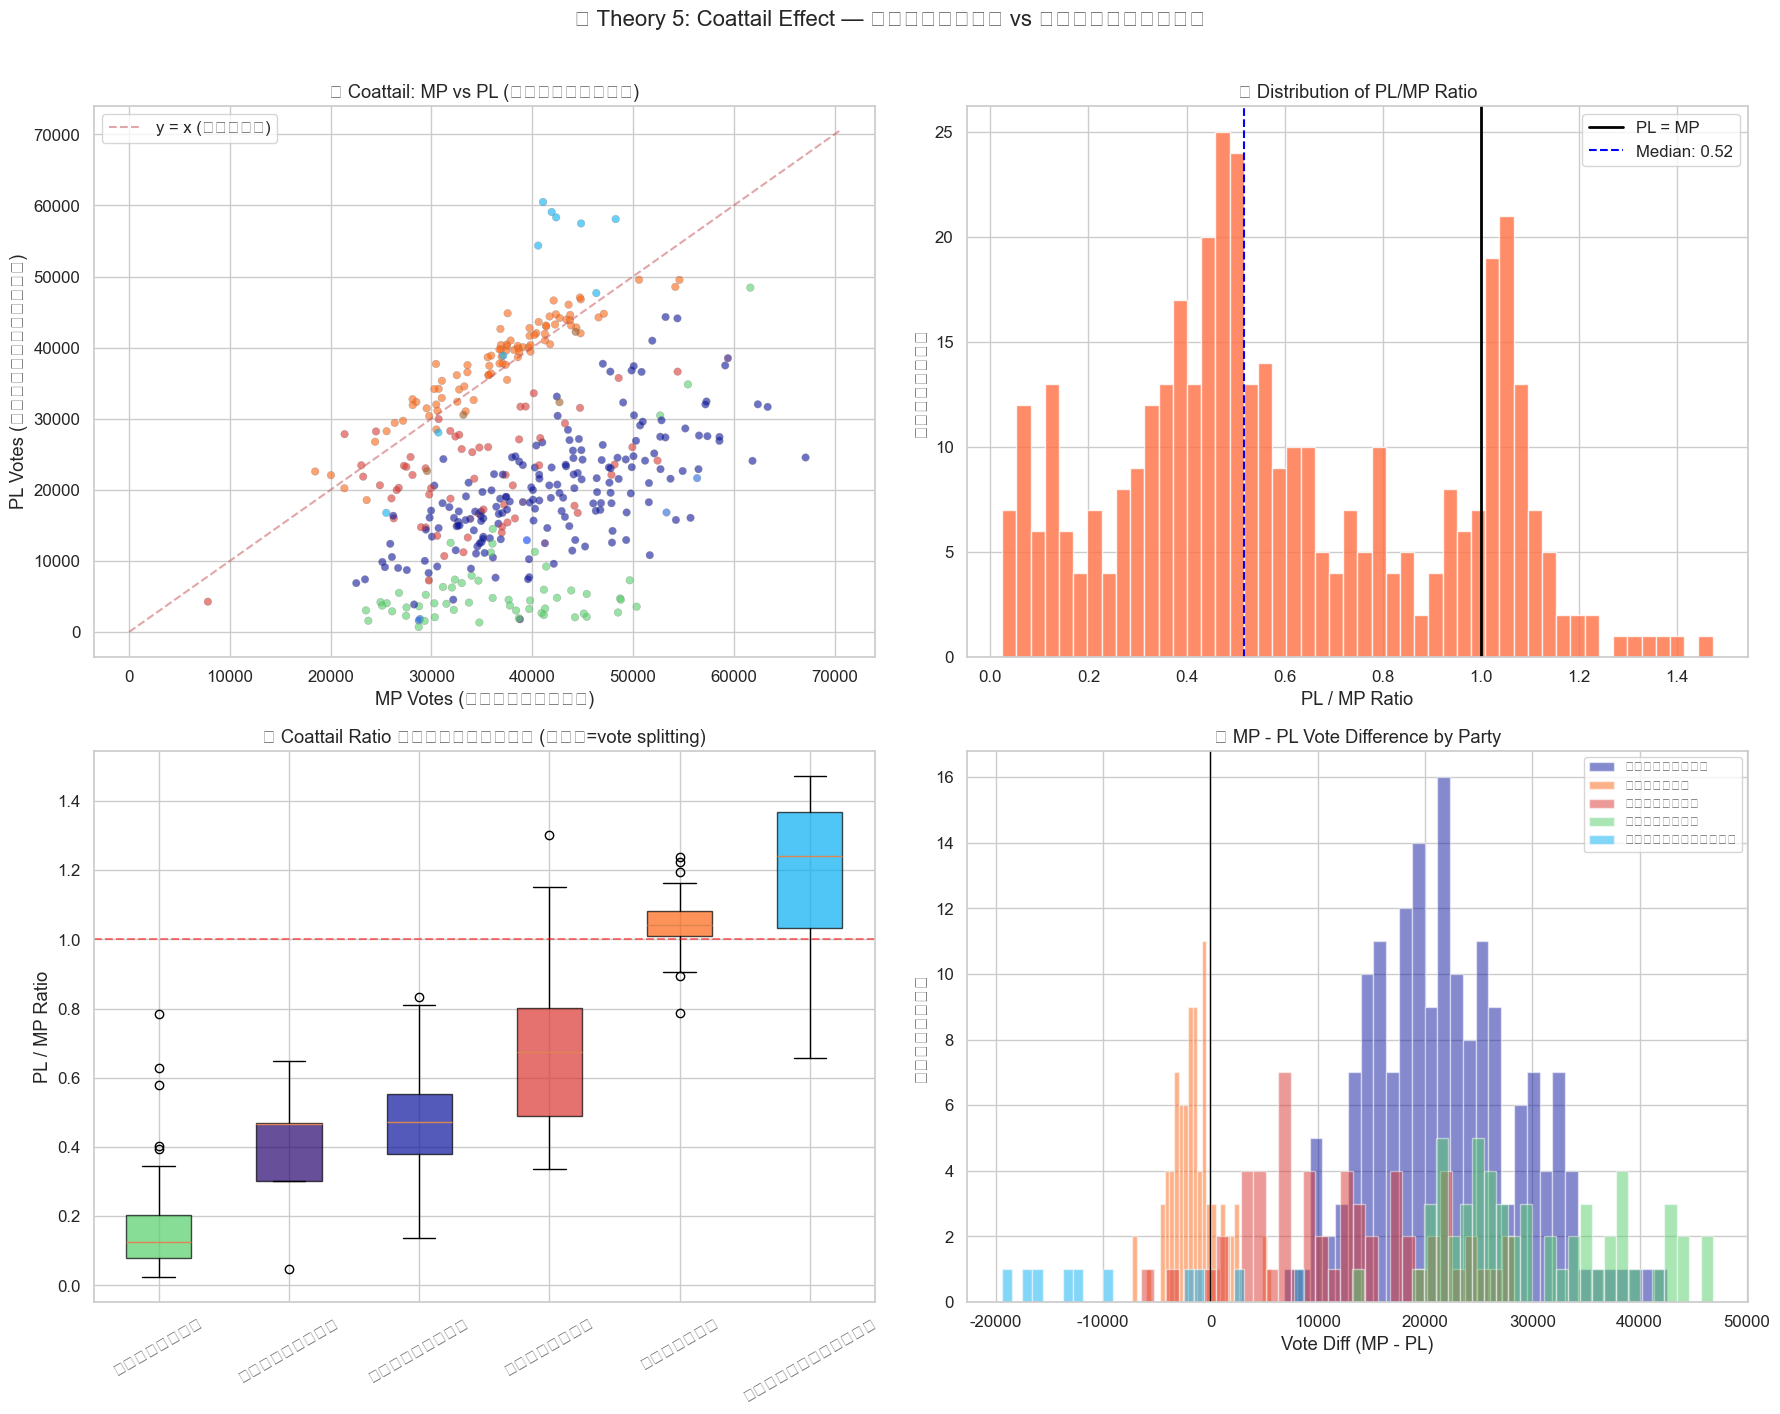

In [8]:
# === Theory 5: Coattail Effect ===

# For each constituency, compare the WINNER's party MP votes vs PL votes
coattail_rows = []

# First compute national totals per party (PL)
party_pl_national = defaultdict(int)
party_mp_national = defaultdict(int)

for code, d in pl_all.items():
    for e in d['entries']:
        party_pl_national[e['partyCode']] += e['voteTotal']

for code, d in mp_all.items():
    for e in d['entries']:
        party_mp_national[e['partyCode']] += e['voteTotal']

for code in mp_all:
    if code not in pl_all:
        continue
    mp_d = mp_all[code]
    pl_d = pl_all[code]
    
    # Winner's party
    winner = next((e for e in mp_d['entries'] if e['rank'] == 1), None)
    if not winner:
        continue
    
    wp = winner['partyCode']
    mp_local = winner['voteTotal']
    
    # PL votes for the same party in this constituency
    pl_local = next((e['voteTotal'] for e in pl_d['entries'] if e['partyCode'] == wp), 0)
    
    mp_nat = party_mp_national.get(wp, 1)
    pl_nat = party_pl_national.get(wp, 1)
    
    # Coattail score
    mp_share = mp_local / mp_nat if mp_nat > 0 else 0
    pl_share = pl_local / pl_nat if pl_nat > 0 else 0
    
    coattail = pl_share / mp_share if mp_share > 0 else 0
    
    # Simple ratio: PL / MP in this area
    simple_ratio = pl_local / mp_local if mp_local > 0 else 0
    
    coattail_rows.append({
        'code_num': code,
        'area_name': area_name_map.get(code, code),
        'winnerParty': wp,
        'winnerPartyName': party_name_map.get(wp, 'Unknown'),
        'mp_local': mp_local,
        'pl_local': pl_local,
        'simple_ratio': simple_ratio,
        'coattail_score': coattail,
        'vote_diff': mp_local - pl_local,
    })

df_t5 = pd.DataFrame(coattail_rows)

print('=' * 70)
print('🔬 Theory 5: Coattail Effect Quantification')
print('=' * 70)
print(f'\n📊 จำนวนเขต: {len(df_t5)}')
print(f'\n--- Simple Ratio (PL / MP ในเขต) ---')
print(f'   ค่าเฉลี่ย: {df_t5["simple_ratio"].mean():.3f}')
print(f'   Median:    {df_t5["simple_ratio"].median():.3f}')
print(f'   <0.5 (vote splitting): {(df_t5["simple_ratio"] < 0.5).sum()} เขต')
print(f'   >1.5 (PL สูงกว่า MP): {(df_t5["simple_ratio"] > 1.5).sum()} เขต')

# Summary by party
print('\n--- เฉลี่ย Simple Ratio แยกตามพรรค ---')
party_summary = df_t5.groupby('winnerPartyName').agg(
    n_areas=('code_num', 'count'),
    avg_ratio=('simple_ratio', 'mean'),
    median_ratio=('simple_ratio', 'median'),
    avg_diff=('vote_diff', 'mean'),
).sort_values('n_areas', ascending=False).head(10)
print(party_summary.to_string())

# Plots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Scatter: MP votes vs PL votes per constituency
ax = axes[0, 0]
colors = [party_color_map.get(wp, '#888') for wp in df_t5['winnerParty']]
ax.scatter(df_t5['mp_local'], df_t5['pl_local'], c=colors, alpha=0.6, s=30, edgecolors='gray', linewidth=0.3)
max_v = max(df_t5['mp_local'].max(), df_t5['pl_local'].max()) * 1.05
ax.plot([0, max_v], [0, max_v], 'r--', alpha=0.5, label='y = x (สมดุล)')
ax.set_xlabel('MP Votes (ผู้ชนะเขต)')
ax.set_ylabel('PL Votes (พรรคเดียวกัน)')
ax.set_title('📊 Coattail: MP vs PL (สีตามพรรค)')
ax.legend()

# 2. Histogram of simple ratio
ax = axes[0, 1]
ax.hist(df_t5['simple_ratio'].clip(0, 3), bins=50, color='#FF7043', edgecolor='white', alpha=0.8)
ax.axvline(x=1.0, color='black', linestyle='-', linewidth=2, label='PL = MP')
ax.axvline(x=df_t5['simple_ratio'].median(), color='blue', linestyle='--', label=f'Median: {df_t5["simple_ratio"].median():.2f}')
ax.set_xlabel('PL / MP Ratio')
ax.set_ylabel('จำนวนเขต')
ax.set_title('📊 Distribution of PL/MP Ratio')
ax.legend()

# 3. Box by party
ax = axes[1, 0]
top_p = df_t5['winnerPartyName'].value_counts().head(6).index.tolist()
df_p5 = df_t5[df_t5['winnerPartyName'].isin(top_p)]
p_order = df_p5.groupby('winnerPartyName')['simple_ratio'].median().sort_values().index
bp = ax.boxplot([df_p5[df_p5['winnerPartyName'] == p]['simple_ratio'] for p in p_order],
                labels=p_order, patch_artist=True, vert=True)
for patch, pname in zip(bp['boxes'], p_order):
    matching = df_t5[df_t5['winnerPartyName'] == pname]['winnerParty'].iloc[0]
    patch.set_facecolor(party_color_map.get(matching, '#888'))
    patch.set_alpha(0.7)
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5)
ax.set_ylabel('PL / MP Ratio')
ax.set_title('📊 Coattail Ratio แยกตามพรรค (ต่ำ=vote splitting)')
ax.tick_params(axis='x', rotation=30)

# 4. Vote diff distribution by party (MP - PL)
ax = axes[1, 1]
for party in top_p[:5]:
    subset = df_t5[df_t5['winnerPartyName'] == party]['vote_diff']
    matching = df_t5[df_t5['winnerPartyName'] == party]['winnerParty'].iloc[0]
    ax.hist(subset, bins=30, alpha=0.5, label=party, color=party_color_map.get(matching, '#888'))
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Vote Diff (MP - PL)')
ax.set_ylabel('จำนวนเขต')
ax.set_title('📊 MP - PL Vote Difference by Party')
ax.legend(fontsize=9)

plt.suptitle('🔬 Theory 5: Coattail Effect — ตัวบุคคล vs แบรนด์พรรค', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

---
## 🔬 Theory 6: Zipf's Law for Candidate Votes
**ทฤษฎี:** คะแนนอันดับ r ≈ V₁ / r^s → Fit power law → คำนวณ Zipf exponent (s)  
s สูงผิดปกติ = กระจุกตัวที่คนเดียว, s ต่ำ = กระจายเท่ากันเกินไป

🔬 Theory 6: Zipf's Law for Candidate Votes

📊 จำนวนเขต: 400

--- Zipf Exponent (s) ---
   ค่าเฉลี่ย: 2.415
   Median:    2.365
   Std:       0.387
   R² เฉลี่ย: 0.898

   s > 2.5 (กระจุกตัวสูง): 154 เขต
   s < 0.8 (กระจายเท่ากัน): 0 เขต


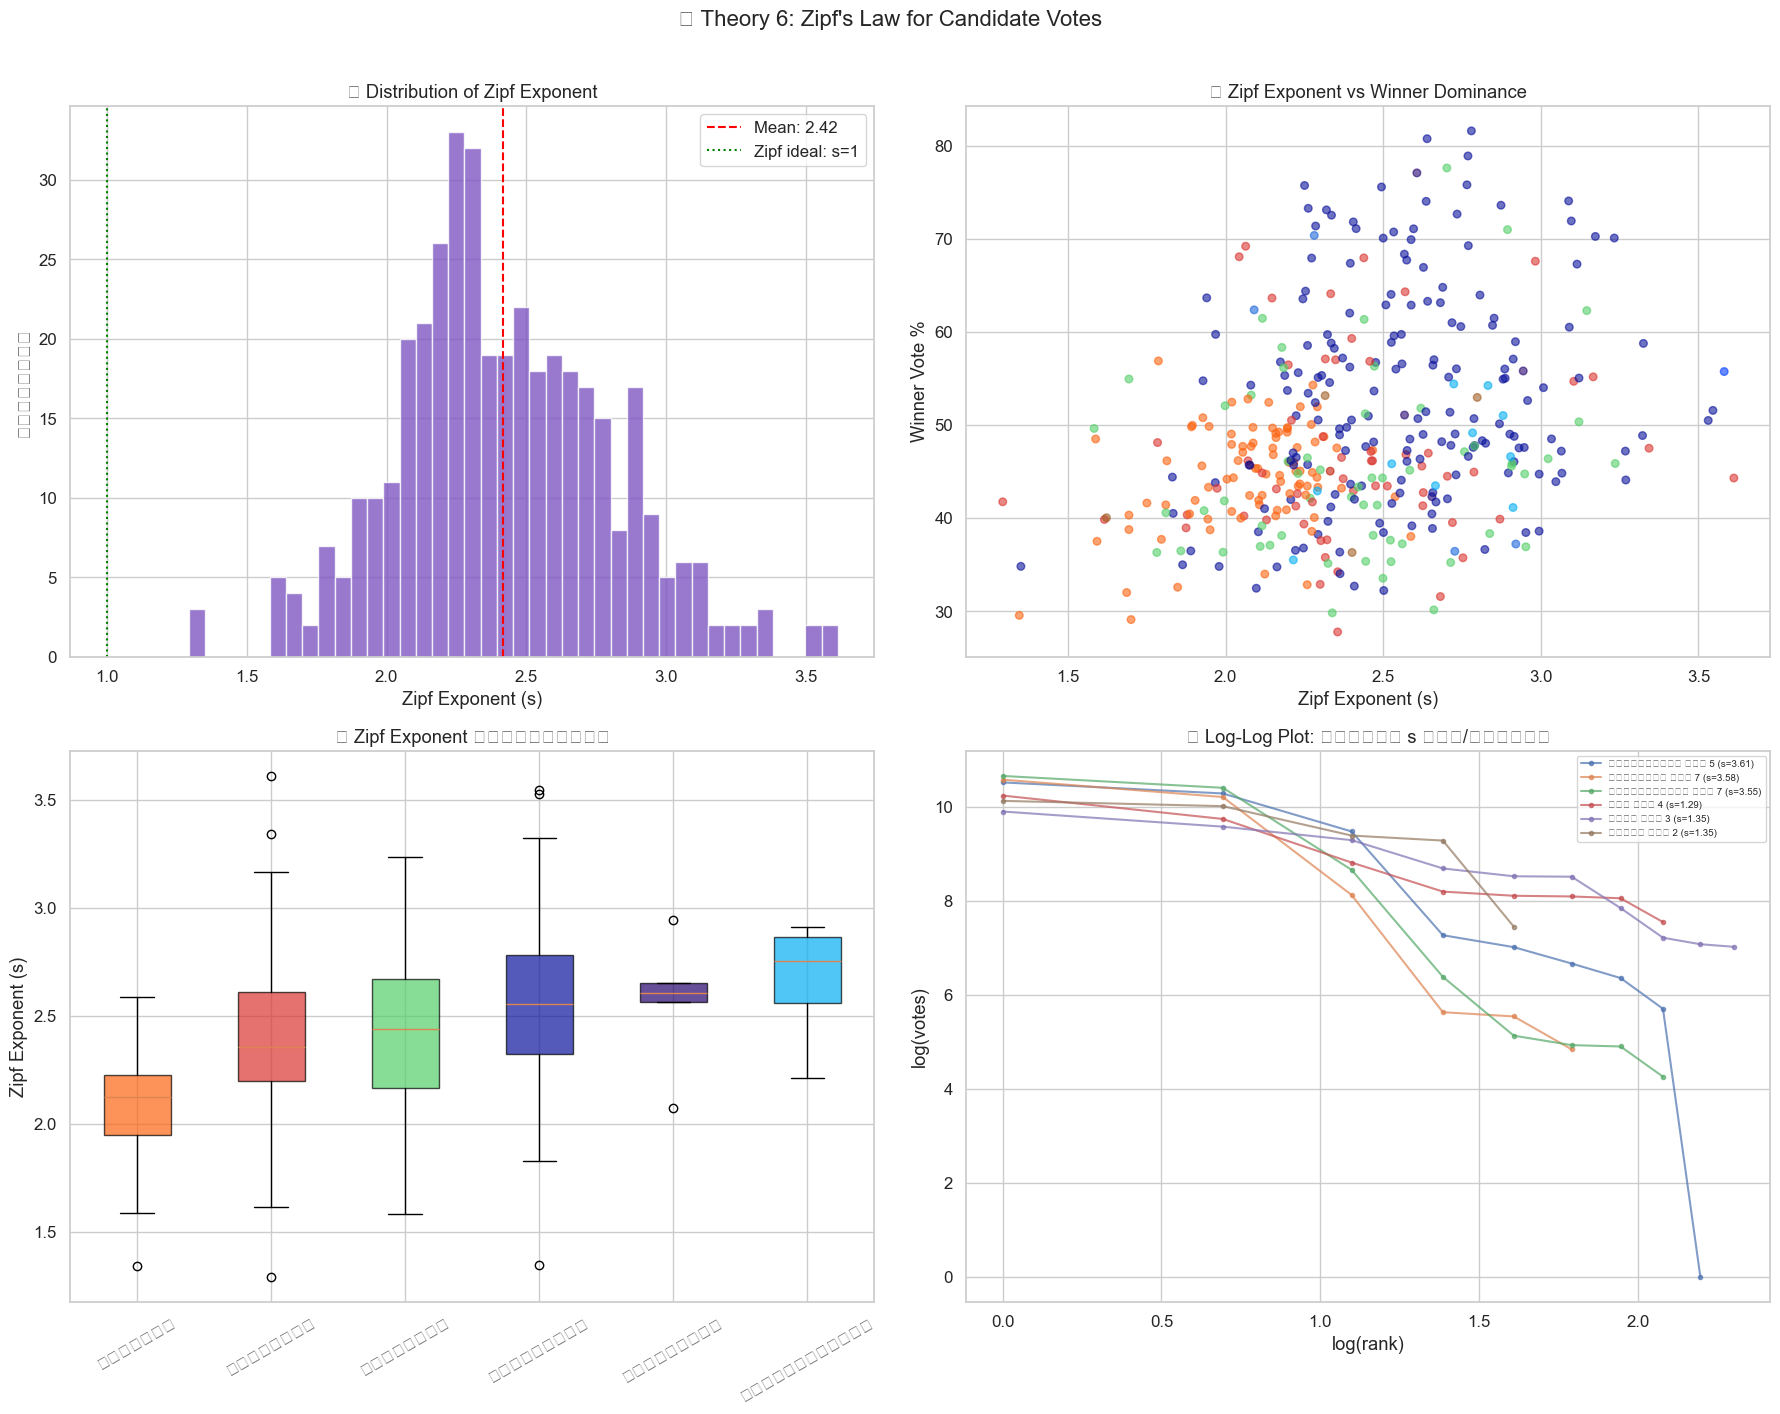


📋 Top 10 เขตที่ s สูงสุด (กระจุกตัวมาก):
        area_name winnerPartyName   zipf_s  r_squared  winner_pct  n_candidates
 นครราชสีมา เขต 5        เพื่อไทย 3.612375   0.669673       44.32             9
   ร้อยเอ็ด เขต 7     ไทยสร้างไทย 3.581743   0.890772       55.75             6
อุบลราชธานี เขต 7       ภูมิใจไทย 3.546011   0.911873       51.58             8
   นราธิวาส เขต 4       ภูมิใจไทย 3.531069   0.914692       50.50             8
   ศรีสะเกษ เขต 7        เพื่อไทย 3.343320   0.905801       47.52             8
      ยโสธร เขต 2       ภูมิใจไทย 3.325478   0.951306       58.77             9
      ยโสธร เขต 1       ภูมิใจไทย 3.322674   0.882129       48.88             7
  นครสวรรค์ เขต 6       ภูมิใจไทย 3.269607   0.874425       44.11             8
  มหาสารคาม เขต 3       ภูมิใจไทย 3.268225   0.933729       47.21            11
   นราธิวาส เขต 3        กล้าธรรม 3.236019   0.904473       45.88             7

📋 Top 10 เขตที่ s ต่ำสุด (กระจายตัว):
        area_name winnerPartyName   zip

In [9]:
# === Theory 6: Zipf's Law for Candidate Votes ===

zipf_rows = []

for code, d in mp_all.items():
    entries = sorted(d['entries'], key=lambda x: x['rank'])
    if len(entries) < 3:
        continue
    
    votes = [e['voteTotal'] for e in entries if e['voteTotal'] > 0]
    ranks = list(range(1, len(votes) + 1))
    
    if len(votes) < 3 or votes[0] == 0:
        continue
    
    # Fit log-log regression: log(vote) = log(V1) - s * log(rank)
    log_ranks = np.log(ranks)
    log_votes = np.log(votes)
    
    slope, intercept, r_value, p_value, std_err = sp_stats.linregress(log_ranks, log_votes)
    
    zipf_rows.append({
        'code_num': code,
        'area_name': area_name_map.get(code, code),
        'winnerParty': entries[0]['partyCode'],
        'winnerPartyName': party_name_map.get(entries[0]['partyCode'], 'Unknown'),
        'zipf_s': -slope,  # Zipf exponent (positive)
        'r_squared': r_value**2,
        'n_candidates': len(votes),
        'winner_pct': entries[0].get('votePercent', 0),
        'margin': entries[0].get('votePercent', 0) - entries[1].get('votePercent', 0) if len(entries) > 1 else 0,
    })

df_t6 = pd.DataFrame(zipf_rows)

print('=' * 70)
print('🔬 Theory 6: Zipf\'s Law for Candidate Votes')
print('=' * 70)
print(f'\n📊 จำนวนเขต: {len(df_t6)}')
print(f'\n--- Zipf Exponent (s) ---')
print(f'   ค่าเฉลี่ย: {df_t6["zipf_s"].mean():.3f}')
print(f'   Median:    {df_t6["zipf_s"].median():.3f}')
print(f'   Std:       {df_t6["zipf_s"].std():.3f}')
print(f'   R² เฉลี่ย: {df_t6["r_squared"].mean():.3f}')
print(f'\n   s > 2.5 (กระจุกตัวสูง): {(df_t6["zipf_s"] > 2.5).sum()} เขต')
print(f'   s < 0.8 (กระจายเท่ากัน): {(df_t6["zipf_s"] < 0.8).sum()} เขต')

# Plots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Histogram of Zipf exponent
ax = axes[0, 0]
ax.hist(df_t6['zipf_s'], bins=40, color='#7E57C2', edgecolor='white', alpha=0.8)
ax.axvline(x=df_t6['zipf_s'].mean(), color='red', linestyle='--', label=f'Mean: {df_t6["zipf_s"].mean():.2f}')
ax.axvline(x=1.0, color='green', linestyle=':', label='Zipf ideal: s=1')
ax.set_xlabel('Zipf Exponent (s)')
ax.set_ylabel('จำนวนเขต')
ax.set_title('📊 Distribution of Zipf Exponent')
ax.legend()

# 2. Scatter: Zipf s vs Winner %
ax = axes[0, 1]
colors = [party_color_map.get(wp, '#888') for wp in df_t6['winnerParty']]
ax.scatter(df_t6['zipf_s'], df_t6['winner_pct'], c=colors, alpha=0.6, s=30)
ax.set_xlabel('Zipf Exponent (s)')
ax.set_ylabel('Winner Vote %')
ax.set_title('📊 Zipf Exponent vs Winner Dominance')

# 3. Zipf s by party (boxplot)
ax = axes[1, 0]
top_p = df_t6['winnerPartyName'].value_counts().head(6).index.tolist()
df_p6 = df_t6[df_t6['winnerPartyName'].isin(top_p)]
p_order = df_p6.groupby('winnerPartyName')['zipf_s'].median().sort_values().index
bp = ax.boxplot([df_p6[df_p6['winnerPartyName'] == p]['zipf_s'] for p in p_order],
                labels=p_order, patch_artist=True, vert=True)
for patch, pname in zip(bp['boxes'], p_order):
    matching = df_t6[df_t6['winnerPartyName'] == pname]['winnerParty'].iloc[0]
    patch.set_facecolor(party_color_map.get(matching, '#888'))
    patch.set_alpha(0.7)
ax.set_ylabel('Zipf Exponent (s)')
ax.set_title('📊 Zipf Exponent แยกตามพรรค')
ax.tick_params(axis='x', rotation=30)

# 4. Example: plot log-log for extreme cases
ax = axes[1, 1]
# Highest and lowest s
high_s = df_t6.nlargest(3, 'zipf_s')
low_s = df_t6.nsmallest(3, 'zipf_s')
examples = pd.concat([high_s, low_s])

for _, row in examples.iterrows():
    d = mp_all[row['code_num']]
    votes = [e['voteTotal'] for e in sorted(d['entries'], key=lambda x: x['rank']) if e['voteTotal'] > 0]
    ranks = range(1, len(votes) + 1)
    label = f"{row['area_name']} (s={row['zipf_s']:.2f})"
    ax.plot(np.log(list(ranks)), np.log(votes), 'o-', markersize=3, alpha=0.7, label=label)

ax.set_xlabel('log(rank)')
ax.set_ylabel('log(votes)')
ax.set_title('📊 Log-Log Plot: เขตที่ s สูง/ต่ำสุด')
ax.legend(fontsize=7)

plt.suptitle('🔬 Theory 6: Zipf\'s Law for Candidate Votes', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

# Extreme tables
print('\n📋 Top 10 เขตที่ s สูงสุด (กระจุกตัวมาก):')
print(df_t6.nlargest(10, 'zipf_s')[['area_name', 'winnerPartyName', 'zipf_s', 'r_squared', 'winner_pct', 'n_candidates']].to_string(index=False))
print('\n📋 Top 10 เขตที่ s ต่ำสุด (กระจายตัว):')
print(df_t6.nsmallest(10, 'zipf_s')[['area_name', 'winnerPartyName', 'zipf_s', 'r_squared', 'winner_pct', 'n_candidates']].to_string(index=False))

---
## 🔬 Theory 7: Party-Specific Benford's Law
**ทฤษฎี:** แยก Benford's Law (1st digit) **รายพรรค** → พรรคไหน fail = น่าสงสัย  
ใช้ Chi-square test per party

🔬 Theory 7: Party-Specific Benford's Law

--- สส.แบ่งเขต (MP) ---
  ประชาชน              n= 399  χ²=   40.57  p=0.000003  ⚠️ FAIL
  ประชาธิปัตย์         n= 398  χ²=   18.11  p=0.020415  ⚠️ FAIL
  เพื่อไทย             n= 396  χ²=   30.11  p=0.000202  ⚠️ FAIL
  ภูมิใจไทย            n= 394  χ²=   85.86  p=0.000000  ⚠️ FAIL
  กล้าธรรม             n= 326  χ²=   30.18  p=0.000197  ⚠️ FAIL
  เศรษฐกิจ             n= 262  χ²=   82.66  p=0.000000  ⚠️ FAIL
  รวมไทยสร้างชาติ      n= 245  χ²=   11.78  p=0.161315  ✅ PASS
  พลังประชารัฐ         n= 193  χ²=    7.86  p=0.447319  ✅ PASS
  ไทยก้าวใหม่          n= 133  χ²=   16.73  p=0.033010  ⚠️ FAIL
  ปวงชนไทย             n=  96  χ²=   16.48  p=0.036038  ⚠️ FAIL
  โอกาสใหม่            n=  73  χ²=    9.78  p=0.281163  ✅ PASS
  ไทยสร้างไทย          n=  68  χ²=   15.17  p=0.055907  ✅ PASS
  ประชาธิปไตยใหม่      n=  68  χ²=    6.23  p=0.621033  ✅ PASS
  พลวัต                n=  61  χ²=   12.08  p=0.147805  ✅ PASS
  ทางเลือกใหม่         n=  43  χ²=   11.17  

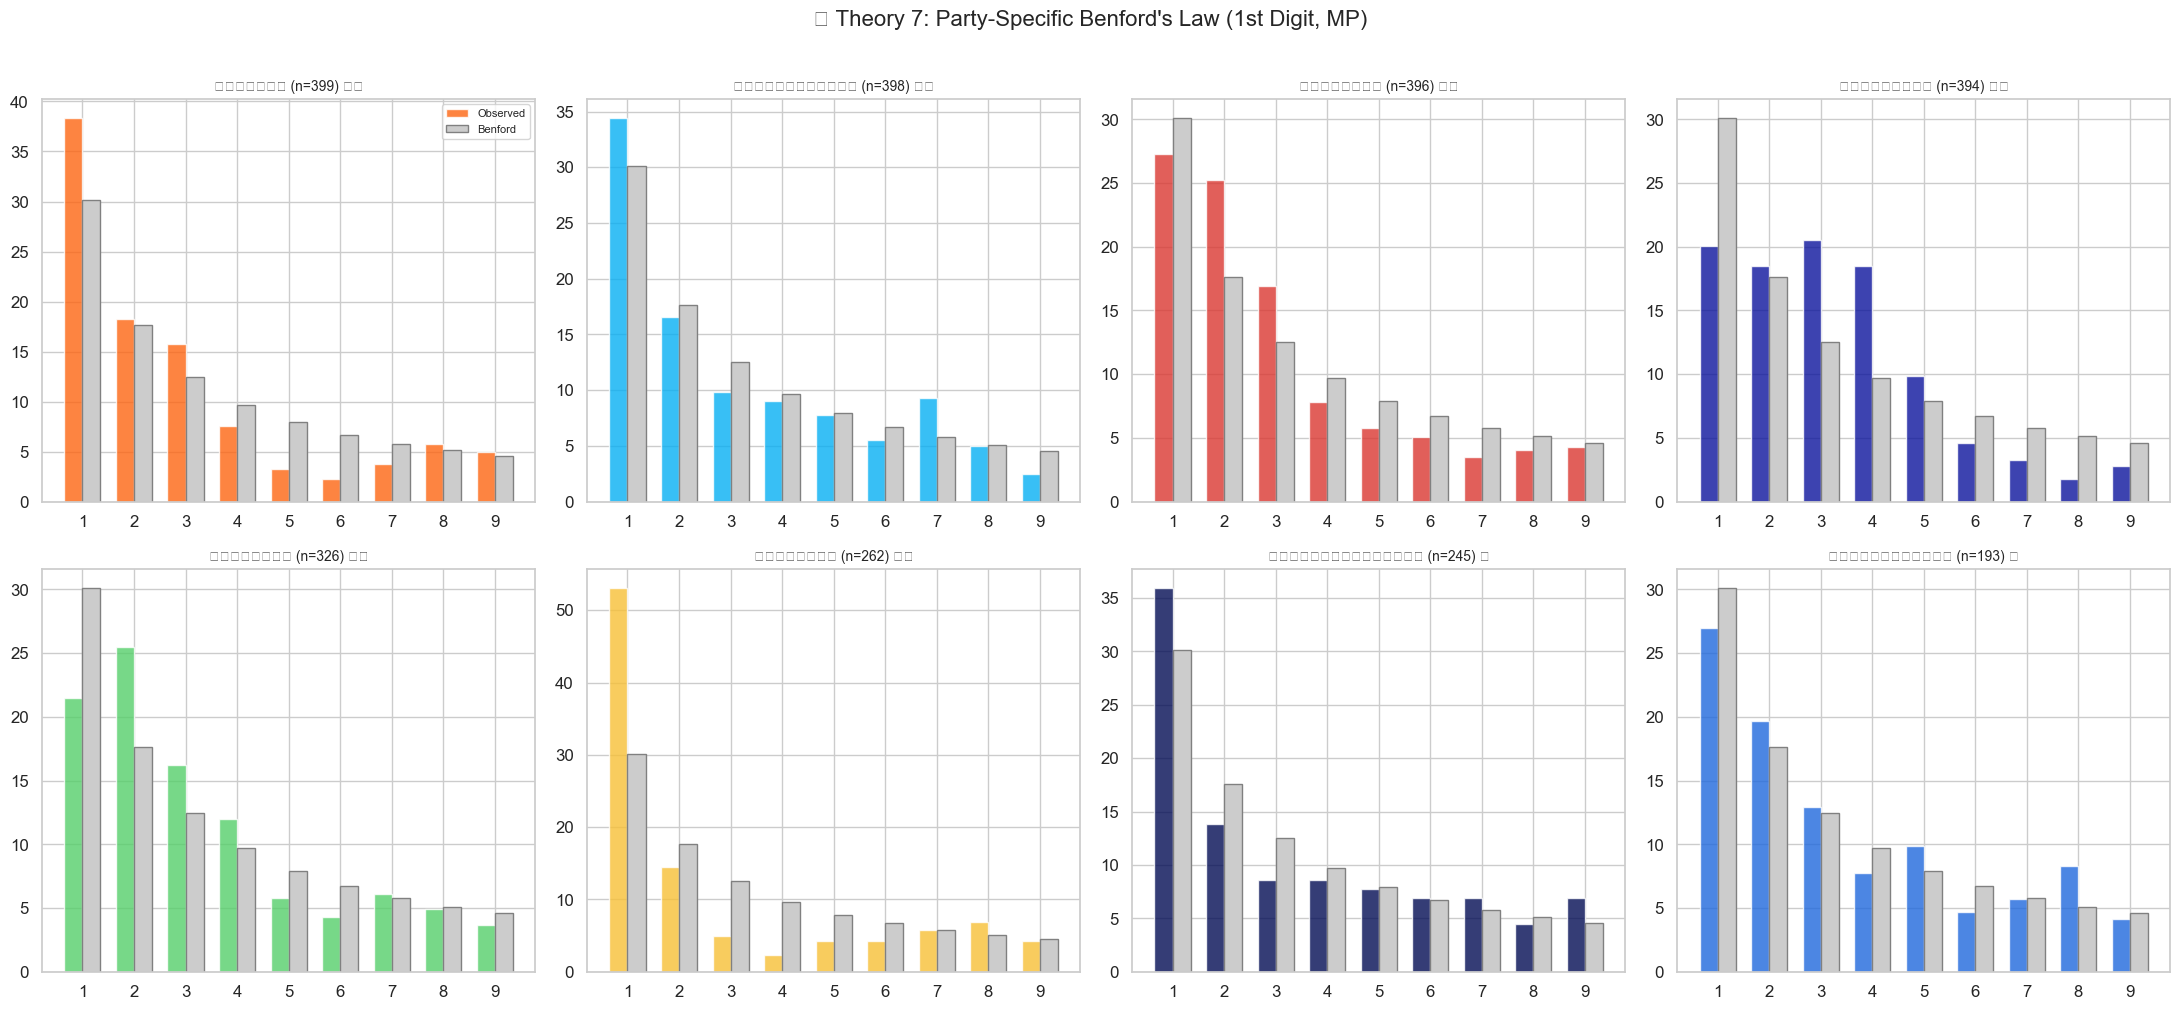

In [10]:
# === Theory 7: Party-Specific Benford's Law ===

# Benford expected proportions for 1st digit
benford_expected = [np.log10(1 + 1/d) for d in range(1, 10)]

# Collect 1st digits per party (from MP votes)
party_first_digits = defaultdict(list)

for code, d in mp_all.items():
    for e in d['entries']:
        v = e['voteTotal']
        if v >= 10:  # need meaningful number
            first_d = int(str(v)[0])
            party_first_digits[e['partyCode']].append(first_d)

# Also from PL
party_first_digits_pl = defaultdict(list)
for code, d in pl_all.items():
    for e in d['entries']:
        v = e['voteTotal']
        if v >= 10:
            first_d = int(str(v)[0])
            party_first_digits_pl[e['partyCode']].append(first_d)

def benford_test(digits, label):
    """Chi-square test for Benford's Law (1st digit)"""
    n = len(digits)
    if n < 30:  # too few data points
        return None
    observed = [digits.count(d) for d in range(1, 10)]
    expected = [n * p for p in benford_expected]
    chi2, p_val = sp_stats.chisquare(observed, expected)
    return {'label': label, 'n': n, 'chi2': chi2, 'p_value': p_val, 'pass': p_val >= 0.05}

# Test top parties (MP)
print('=' * 70)
print('🔬 Theory 7: Party-Specific Benford\'s Law')
print('=' * 70)

benford_results_mp = []
benford_results_pl = []

# Sort parties by total data points
sorted_parties = sorted(party_first_digits.items(), key=lambda x: len(x[1]), reverse=True)

print('\n--- สส.แบ่งเขต (MP) ---')
for party_code, digits in sorted_parties[:15]:
    result = benford_test(digits, party_name_map.get(party_code, party_code))
    if result:
        benford_results_mp.append({**result, 'party_code': party_code})
        status = '✅ PASS' if result['pass'] else '⚠️ FAIL'
        print(f'  {result["label"]:20s} n={result["n"]:4d}  χ²={result["chi2"]:8.2f}  p={result["p_value"]:.6f}  {status}')

print('\n--- บัญชีรายชื่อ (PL) ---')
sorted_pl = sorted(party_first_digits_pl.items(), key=lambda x: len(x[1]), reverse=True)
for party_code, digits in sorted_pl[:15]:
    result = benford_test(digits, party_name_map.get(party_code, party_code))
    if result:
        benford_results_pl.append({**result, 'party_code': party_code})
        status = '✅ PASS' if result['pass'] else '⚠️ FAIL'
        print(f'  {result["label"]:20s} n={result["n"]:4d}  χ²={result["chi2"]:8.2f}  p={result["p_value"]:.6f}  {status}')

# Visualization: top 8 parties MP first-digit distribution vs Benford
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (party_code, digits) in enumerate(sorted_parties[:8]):
    ax = axes[idx]
    pname = party_name_map.get(party_code, party_code)
    n = len(digits)
    observed_pct = [digits.count(d) / n * 100 for d in range(1, 10)]
    expected_pct = [p * 100 for p in benford_expected]
    
    x = range(1, 10)
    width = 0.35
    ax.bar([i - width/2 for i in x], observed_pct, width, label='Observed',
           color=party_color_map.get(party_code, '#888'), alpha=0.8)
    ax.bar([i + width/2 for i in x], expected_pct, width, label='Benford',
           color='#ccc', edgecolor='gray')
    
    # Chi-square result
    result = benford_test(digits, pname)
    status = '✅' if result and result['pass'] else '⚠️'
    ax.set_title(f'{pname} (n={n}) {status}', fontsize=10)
    ax.set_xticks(range(1, 10))
    if idx == 0:
        ax.legend(fontsize=8)

plt.suptitle('🔬 Theory 7: Party-Specific Benford\'s Law (1st Digit, MP)', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

---
## 🔬 Theory 8: Turnout-Share Correlation (Myagkov-Ordeshook)
**ทฤษฎี:** ในเลือกตั้งปกติ Turnout สูง ≠ พรรคเดียวครอง  
แต่ถ้า Turnout สูง + พรรคเดียวครอง = fingerprint ของ ballot stuffing  
วิเคราะห์ regression: Turnout → Winner Share แยกรายพรรค

🔬 Theory 8: Turnout-Share Correlation (Myagkov-Ordeshook)

📊 Overall: r=-0.2089, p=0.000025
   ⚠️ Significant correlation

--- Correlation แยกตามพรรคผู้ชนะ ---
  ภูมิใจไทย            (n=174): r=-0.3907, p=0.000000 ✅
  ประชาชน              (n= 87): r=0.0131, p=0.904459 ✅
  เพื่อไทย             (n= 58): r=-0.1910, p=0.150876 ✅
  กล้าธรรม             (n= 56): r=0.1046, p=0.442909 ✅
  ประชาธิปัตย์         (n= 10): r=0.3297, p=0.352218 ✅


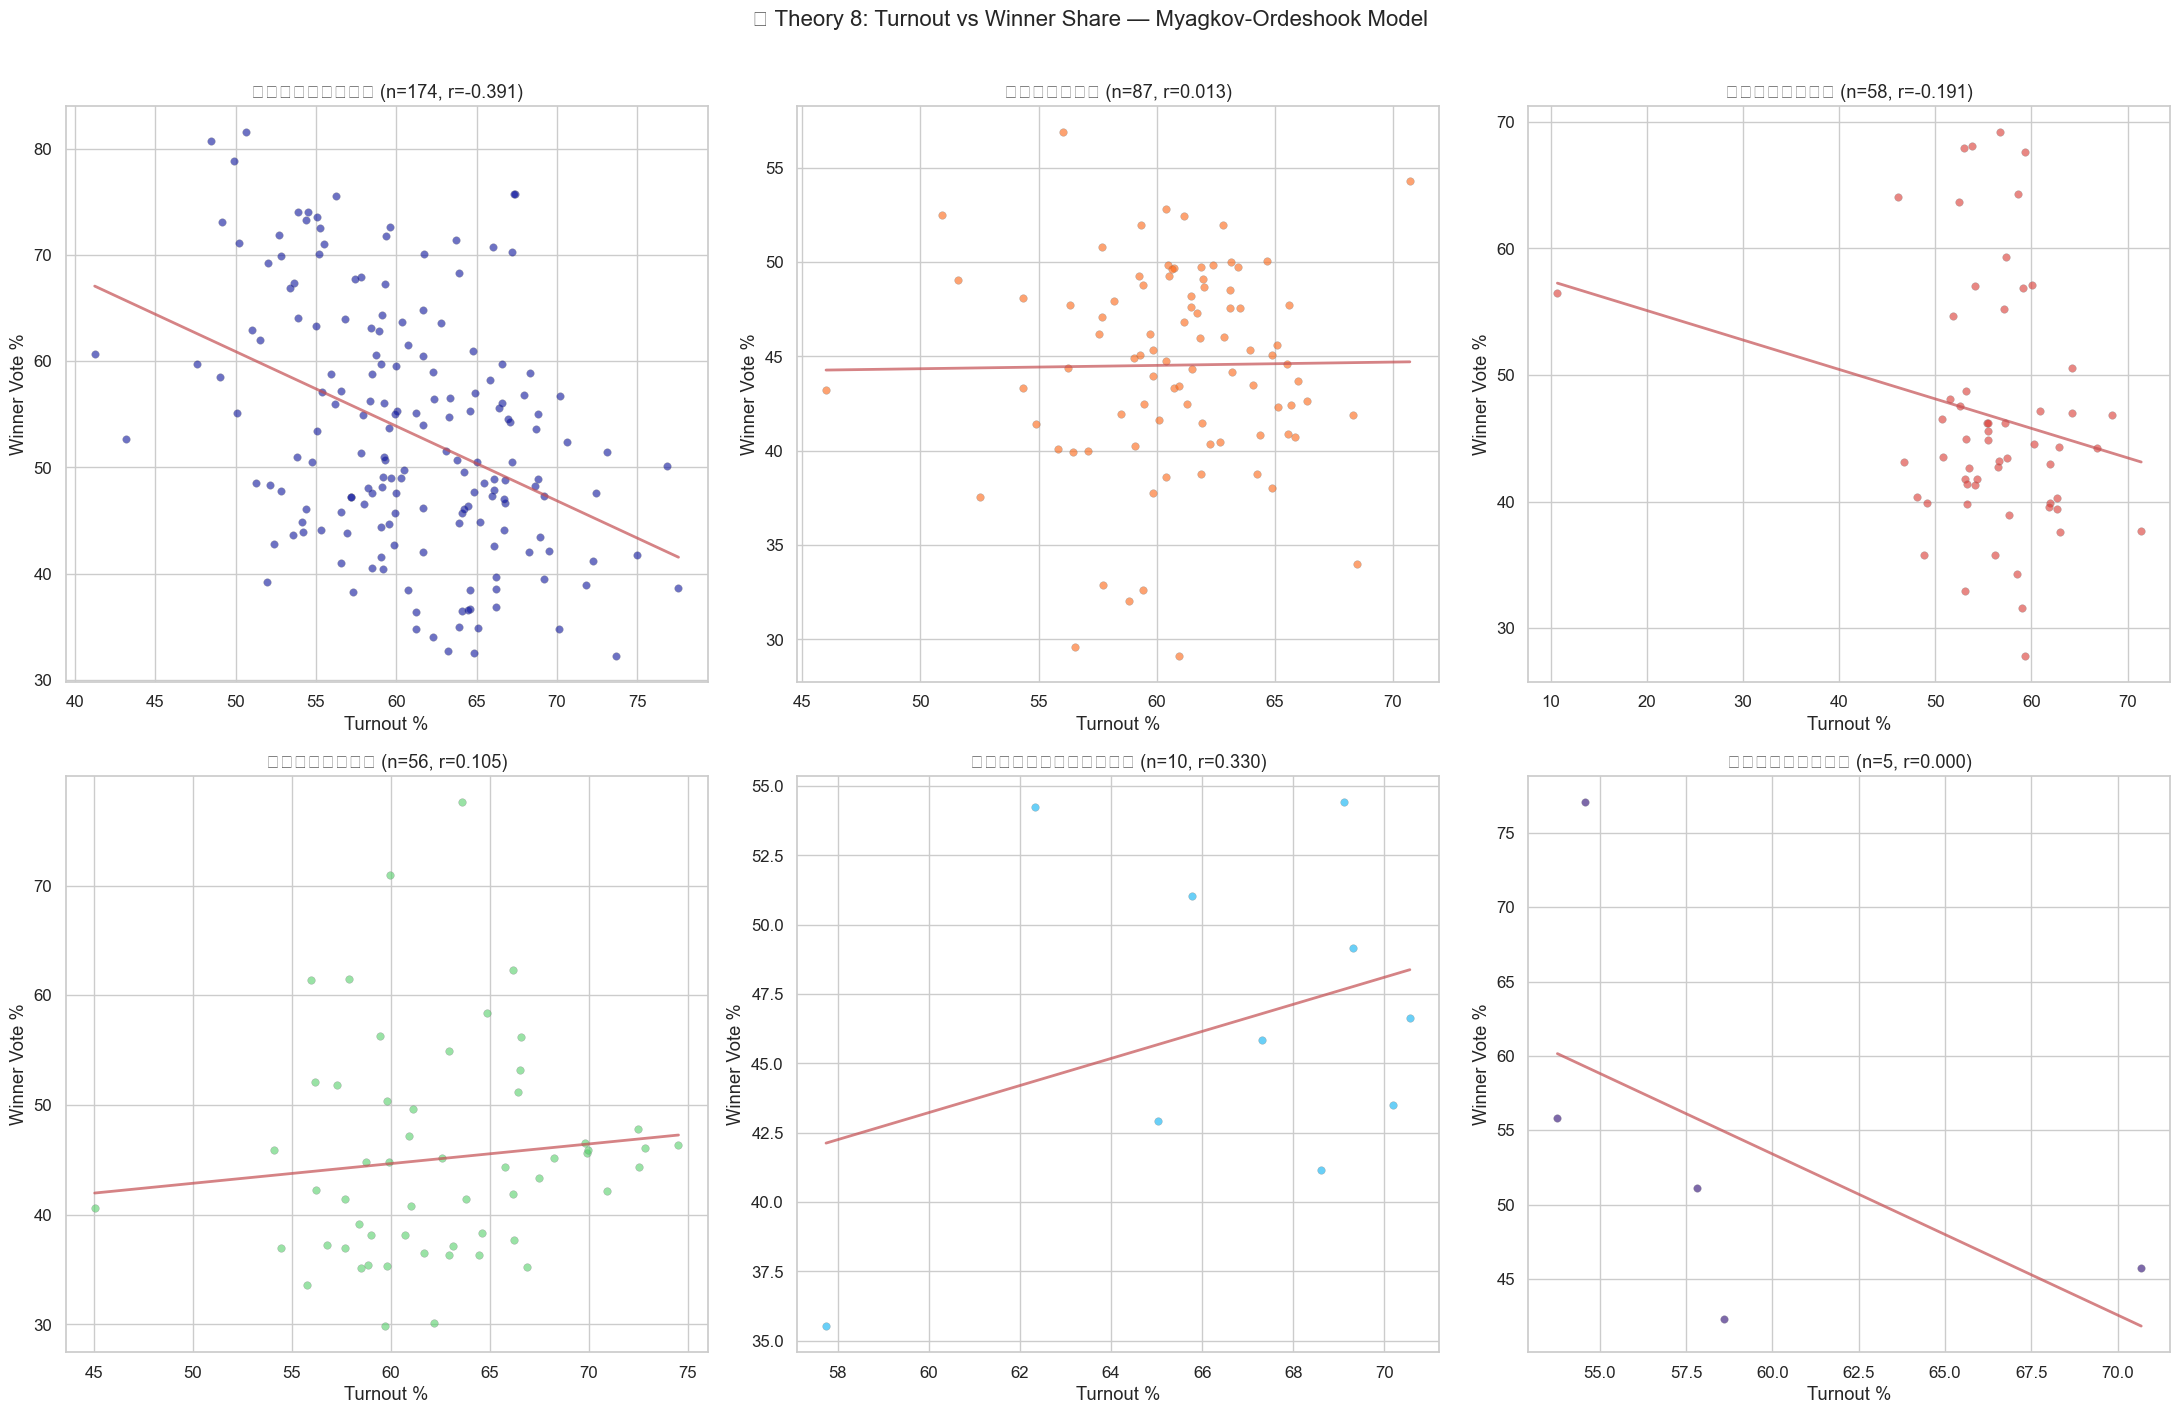


🚩 เขตที่ Turnout > P85 (66.4%) AND Winner > P85 (60.5%): 3 เขต
     area_name winnerPartyName  mp_turnout_pct  winner_pct  margin
 อ่างทอง เขต 2       ภูมิใจไทย           67.35       75.79   58.27
เพชรบุรี เขต 3       ภูมิใจไทย           67.39       75.72   61.60
 อ่างทอง เขต 1       ภูมิใจไทย           67.19       70.25   47.69


In [11]:
# === Theory 8: Turnout-Share Correlation (Myagkov-Ordeshook) ===

df_t8 = df[df['totalEligible'] > 0].copy()
df_t8 = df_t8[df_t8['mp_turnout_pct'] > 0].copy()

# Overall correlation
corr_overall, p_overall = sp_stats.pearsonr(df_t8['mp_turnout_pct'], df_t8['winner_pct'])

print('=' * 70)
print('🔬 Theory 8: Turnout-Share Correlation (Myagkov-Ordeshook)')
print('=' * 70)
print(f'\n📊 Overall: r={corr_overall:.4f}, p={p_overall:.6f}')
print(f'   {"⚠️ Significant correlation" if p_overall < 0.05 else "✅ No significant correlation"}')

# Per-party correlation
print('\n--- Correlation แยกตามพรรคผู้ชนะ ---')
party_corr_results = []
top_parties = df_t8['winnerPartyName'].value_counts().head(8).index.tolist()

for party in top_parties:
    subset = df_t8[df_t8['winnerPartyName'] == party]
    if len(subset) < 10:
        continue
    r, p = sp_stats.pearsonr(subset['mp_turnout_pct'], subset['winner_pct'])
    party_code = subset['winnerParty'].iloc[0]
    status = '⚠️' if p < 0.05 and r > 0.2 else '✅'
    print(f'  {party:20s} (n={len(subset):3d}): r={r:.4f}, p={p:.6f} {status}')
    party_corr_results.append({'party': party, 'party_code': party_code, 'n': len(subset), 'r': r, 'p': p})

# Plots
n_parties = min(len(top_parties), 6)
fig, axes = plt.subplots(2, 3, figsize=(22, 14))
axes = axes.flatten()

for idx, party in enumerate(top_parties[:6]):
    ax = axes[idx]
    subset = df_t8[df_t8['winnerPartyName'] == party]
    party_code = subset['winnerParty'].iloc[0]
    color = party_color_map.get(party_code, '#888')
    
    ax.scatter(subset['mp_turnout_pct'], subset['winner_pct'], c=color, alpha=0.6, s=30, edgecolors='gray', linewidth=0.3)
    
    # Regression line
    if len(subset) > 2:
        z = np.polyfit(subset['mp_turnout_pct'], subset['winner_pct'], 1)
        p_line = np.poly1d(z)
        x_range = np.linspace(subset['mp_turnout_pct'].min(), subset['mp_turnout_pct'].max(), 100)
        ax.plot(x_range, p_line(x_range), 'r-', alpha=0.7, linewidth=2)
    
    r_val = party_corr_results[idx]['r'] if idx < len(party_corr_results) else 0
    ax.set_xlabel('Turnout %')
    ax.set_ylabel('Winner Vote %')
    ax.set_title(f'{party} (n={len(subset)}, r={r_val:.3f})')

plt.suptitle('🔬 Theory 8: Turnout vs Winner Share — Myagkov-Ordeshook Model', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

# Flag suspicious: high turnout + high winner share
turnout_hi = df_t8['mp_turnout_pct'].quantile(0.85)
winner_hi = df_t8['winner_pct'].quantile(0.85)
flagged = df_t8[(df_t8['mp_turnout_pct'] > turnout_hi) & (df_t8['winner_pct'] > winner_hi)]

print(f'\n🚩 เขตที่ Turnout > P85 ({turnout_hi:.1f}%) AND Winner > P85 ({winner_hi:.1f}%): {len(flagged)} เขต')
if len(flagged) > 0:
    print(flagged.nlargest(15, 'winner_pct')[['area_name', 'winnerPartyName', 'mp_turnout_pct', 'winner_pct', 'margin']].to_string(index=False))

---
## 📊 สรุปรวม: ผลการวิเคราะห์ทั้ง 8 ทฤษฎี

In [12]:
# === Summary of All Theories ===

print('=' * 70)
print('📊 สรุปรวม: ผลการวิเคราะห์ 8 ทฤษฎีเชิงลึก')
print('=' * 70)

summary = [
    ['1. Referendum Cross-Validation',
     f'Turnout diff mean={df_t1["turnout_diff"].mean():.2f}%, outliers={df_t1["turnout_outlier"].sum()} เขต',
     'ดู turnout gap + แยกตามพรรค'],
    ['2. Ecological Inference',
     f'Transition matrix {len(main_66)} พรรคหลัก',
     'ดูการย้ายฐานเสียง 66→69'],
    ['3. Digit Pair Correlation',
     'Chi-square ทดสอบ last/tens/2-digit',
     'ดูว่ามีการ "แต่ง" ตัวเลขหรือไม่'],
    ['4. Ballot Completion Rate',
     f'Suspicious combos: {df_t4["suspicious_combo"].sum()} เขต',
     'high completion + high turnout'],
    ['5. Coattail Effect',
     f'PL/MP ratio mean={df_t5["simple_ratio"].mean():.3f}',
     'วัดอิทธิพลหัวขบวน แยกตามพรรค'],
    ['6. Zipf\'s Law',
     f'Zipf s mean={df_t6["zipf_s"].mean():.2f}, R²={df_t6["r_squared"].mean():.3f}',
     'ดูการกระจุกตัว/กระจายของคะแนน'],
    ['7. Party-Specific Benford',
     f'{sum(1 for r in benford_results_mp if not r["pass"])}/{len(benford_results_mp)} พรรค fail (MP)',
     'Benford แยกรายพรรค'],
    ['8. Turnout-Share Correlation',
     f'Overall r={corr_overall:.4f}, flagged={len(flagged)} เขต',
     'Myagkov-Ordeshook model'],
]

for theory, result, note in summary:
    print(f'\n🔬 {theory}')
    print(f'   ผลลัพธ์: {result}')
    print(f'   หมายเหตุ: {note}')

print('\n' + '=' * 70)
print('💡 เลือกทฤษฎีที่สนใจไปเพิ่มใน Dashboard ได้เลย!')
print('=' * 70)

📊 สรุปรวม: ผลการวิเคราะห์ 8 ทฤษฎีเชิงลึก

🔬 1. Referendum Cross-Validation
   ผลลัพธ์: Turnout diff mean=-4.40%, outliers=254 เขต
   หมายเหตุ: ดู turnout gap + แยกตามพรรค

🔬 2. Ecological Inference
   ผลลัพธ์: Transition matrix 8 พรรคหลัก
   หมายเหตุ: ดูการย้ายฐานเสียง 66→69

🔬 3. Digit Pair Correlation
   ผลลัพธ์: Chi-square ทดสอบ last/tens/2-digit
   หมายเหตุ: ดูว่ามีการ "แต่ง" ตัวเลขหรือไม่

🔬 4. Ballot Completion Rate
   ผลลัพธ์: Suspicious combos: 6 เขต
   หมายเหตุ: high completion + high turnout

🔬 5. Coattail Effect
   ผลลัพธ์: PL/MP ratio mean=0.597
   หมายเหตุ: วัดอิทธิพลหัวขบวน แยกตามพรรค

🔬 6. Zipf's Law
   ผลลัพธ์: Zipf s mean=2.42, R²=0.898
   หมายเหตุ: ดูการกระจุกตัว/กระจายของคะแนน

🔬 7. Party-Specific Benford
   ผลลัพธ์: 8/15 พรรค fail (MP)
   หมายเหตุ: Benford แยกรายพรรค

🔬 8. Turnout-Share Correlation
   ผลลัพธ์: Overall r=-0.2089, flagged=3 เขต
   หมายเหตุ: Myagkov-Ordeshook model

💡 เลือกทฤษฎีที่สนใจไปเพิ่มใน Dashboard ได้เลย!
